In [ ]:
pip install wordcloud

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import json
import io
from AutoClusterHPO import AutoClusterHPO
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import json


pd.set_option('display.float_format', '{:.2f}'.format)

c:\Users\user\Downloads\modulo_gestao_conteudo\modulo_gestao_conteudo_av\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
from docx import Document
from docx.enum.style import WD_STYLE_TYPE

# Crie um novo documento para ver os estilos padrão
# ou abra um documento existente com Document('seu_documento.docx')
document = Document()

# Obtenha todos os estilos do documento
styles = document.styles

# Filtre para obter apenas os estilos de parágrafo
paragraph_styles = [
    s for s in styles if s.type == WD_STYLE_TYPE.PARAGRAPH
]

# Imprima o nome de cada estilo de parágrafo
for style in paragraph_styles:
    print(style.name)

Normal
Header
Footer
Heading 1
Heading 2
Heading 3
Heading 4
Heading 5
Heading 6
Heading 7
Heading 8
Heading 9
No Spacing
Title
Subtitle
List Paragraph
Body Text
Body Text 2
Body Text 3
List
List 2
List 3
List Bullet
List Bullet 2
List Bullet 3
List Number
List Number 2
List Number 3
List Continue
List Continue 2
List Continue 3
macro
Quote
Caption
Intense Quote
TOC Heading


# Leitura de Dados

In [68]:
profile_df = pd.read_json(r'..\data\raw\profile_data.json')
posts_df = pd.read_json(r'..\data\raw\post_data.json')

# Gerar Dataframes com Quantitativas de Perfis
cols_int = profile_df.columns[profile_df.dtypes == 'int64']
cols = ['username'] + cols_int.tolist()
profile_df_int = profile_df[cols].copy()

# Gerar Dataframes com Quantitativas de Posts
cols_int = posts_df.columns[posts_df.dtypes == 'int64']
cols = ['ownerUsername', 'timestamp'] + cols_int.tolist()
posts_df_int = posts_df[cols].copy()

In [69]:
posts_df.head()

,inputUrl,id,type,shortCode,caption,hashtags,mentions,url,commentsCount,firstComment,...,productType,videoDuration,isSponsored,isPinned,musicInfo,isCommentsDisabled,taggedUsers,coauthorProducers,locationName,locationId
0,https://www.instagram.com/ibaneisoficial,3539964830397148672,Video,DEge0H5Mq4D,Seguiremos firmes para que o nosso Distrito Fe...,[DescriçãoParaTodos:],[],https://www.instagram.com/p/DEge0H5Mq4D/,2592,Tomara que a população acorde e não eleja um d...,...,clips,10.00,False,1.00,"{'artist_name': 'ibaneisoficial', 'song_name':...",False,NaN,NaN,NaN,NaN
1,https://www.instagram.com/ibaneisoficial,3539837564024157696,Video,DEgB4J2PnYc,Seguiremos firmes para que o nosso Distrito Fe...,[DescriçãoParaTodos:],[],https://www.instagram.com/p/DEgB4J2PnYc/,635,"Faraó do concreto, a propaganda é maravilhosa ...",...,clips,62.73,False,1.00,"{'artist_name': 'ibaneisoficial', 'song_name':...",False,NaN,NaN,NaN,NaN
2,https://www.instagram.com/ibaneisoficial,3539743615188160000,Video,DEfshBLP00t,Seguiremos firmes para que o nosso Distrito Fe...,"[EquipeIba, DescriçãoParaTodos:]",[],https://www.instagram.com/p/DEfshBLP00t/,296,RESPEITA A EDUCAÇÃO! A GREVE É CULPANDO GOVERN...,...,clips,37.24,False,1.00,"{'artist_name': 'ibaneisoficial', 'song_name':...",False,NaN,NaN,NaN,NaN
3,https://www.instagram.com/ibaneisoficial,3653527001383163904,Sidecar,DKz73NWvdhr,"Hoje comemoramos mais um Dia dos Namorados, @m...",[],[mayara.noronharocha.],https://www.instagram.com/p/DKz73NWvdhr/,459,"E os deputados com aumento de 5,39% com seus s...",...,NaN,NaN,False,NaN,NaN,False,NaN,NaN,NaN,NaN
4,https://www.instagram.com/ibaneisoficial,3652885411493373952,Video,DKxp-2NROjp,Participei do 2º Brasília Summit Lide para dis...,[],[],https://www.instagram.com/p/DKxp-2NROjp/,474,Um tal governador do DF quer saber quantos dia...,...,clips,63.53,False,NaN,"{'artist_name': 'ibaneisoficial', 'song_name':...",False,NaN,NaN,NaN,NaN


# Limpeza e Tratamento de Dados

Converter 'timestamp' p\ Data

In [70]:
posts_df_int['data_hora'] = pd.to_datetime(posts_df_int['timestamp'])

Agrupar Posts + Reels por 'ownerId' e 'ownerUsername'

In [71]:
posts_df_int_gruped = posts_df_int.groupby(['ownerId', 'ownerUsername']).agg(
    commentsSum=('commentsCount', 'sum'),
    likesSum=('likesCount', 'sum'),
    minData=('data_hora', 'min'),
    maxData=('data_hora', 'max'),
    count=('ownerId', 'count')
).reset_index()

posts_df_int_gruped.head()

,ownerId,ownerUsername,commentsSum,likesSum,minData,maxData,count
0,7999637,claudiocastrorj,19225,92799,2025-05-30 12:49:56+00:00,2025-06-13 14:03:13+00:00,30
1,18449431,nubialima,18,351,2025-06-11 20:29:03+00:00,2025-06-11 20:29:03+00:00,1
2,23552759,virginiamendesoficial,316,1545,2025-06-01 12:00:00+00:00,2025-06-12 11:30:00+00:00,3
3,38151300,valdetario,334,990,2025-05-27 15:07:35+00:00,2025-05-27 15:07:35+00:00,1
4,44117761,danibarbalho,166,2372,2025-06-12 11:07:03+00:00,2025-06-12 11:07:03+00:00,1


Calcular '% ENGAJAMENTO', 'RECENCIA' e 'FREQUENCIA'

In [72]:
profile_df_posts_int = pd.merge(profile_df_int, posts_df_int_gruped, left_on='id', right_on='ownerId', how='left').drop(['ownerId'], axis=1) 
profile_df_posts_int['TOTAL ENGAJAMENTO'] = (profile_df_posts_int['commentsSum'] + profile_df_posts_int['likesSum'])
profile_df_posts_int[r'% ENGAJAMENTO'] =  profile_df_posts_int['TOTAL ENGAJAMENTO'] / profile_df_posts_int['followersCount']
profile_df_posts_int['RECENCIA'] = 1 / ((profile_df_posts_int['maxData'].max() - profile_df_posts_int['maxData']).dt.days + 1)
profile_df_posts_int['FREQUENCIA'] = profile_df_posts_int['count'] / ((profile_df_posts_int['maxData'] - profile_df_posts_int['minData']).dt.days + 1)
 

profile_df_posts_int.head()

,username,id,followersCount,followsCount,highlightReelCount,igtvVideoCount,postsCount,fbid,ownerUsername,commentsSum,likesSum,minData,maxData,count,TOTAL ENGAJAMENTO,% ENGAJAMENTO,RECENCIA,FREQUENCIA
0,jeronimorodriguesba,12547733711,692137,3737,19,145,5246,17841412651338466,jeronimorodriguesba,3705,55140,2025-06-09 14:49:06+00:00,2025-06-14 01:04:19+00:00,30,58845,0.09,1.00,6.00
1,ibaneisoficial,8354690711,192018,3043,3,77,3301,17841408241354336,ibaneisoficial,18573,32693,2025-01-06 19:06:46+00:00,2025-06-13 13:29:00+00:00,29,51266,0.27,1.00,0.18
2,clecioluis_,214942370,159441,6121,7,428,6660,17841400911103358,clecioluis_,9188,55032,2025-06-05 16:56:03+00:00,2025-06-14 00:31:19+00:00,29,64220,0.40,1.00,3.22
3,ronaldocaiado,578026968,1373629,2814,10,439,10122,17841401289049032,ronaldocaiado,27323,419719,2024-08-14 15:37:54+00:00,2025-06-13 22:03:29+00:00,25,447042,0.33,1.00,0.08
4,gladsoncameli,1523264831,173518,6802,6,353,8851,17841400024953800,gladsoncameli,1781,36328,2025-05-27 02:44:55+00:00,2025-06-13 00:51:04+00:00,29,38109,0.22,0.50,1.71


In [73]:
profile_df_posts_int.columns

Index(['username', 'id', 'followersCount', 'followsCount',
       'highlightReelCount', 'igtvVideoCount', 'postsCount', 'fbid',
       'ownerUsername', 'commentsSum', 'likesSum', 'minData', 'maxData',
       'count', 'TOTAL ENGAJAMENTO', '% ENGAJAMENTO', 'RECENCIA',
       'FREQUENCIA'],
      dtype='object')

# Análise de Perfil dos Concorrentes

## Figura 1

Cor alterada com Sucesso!


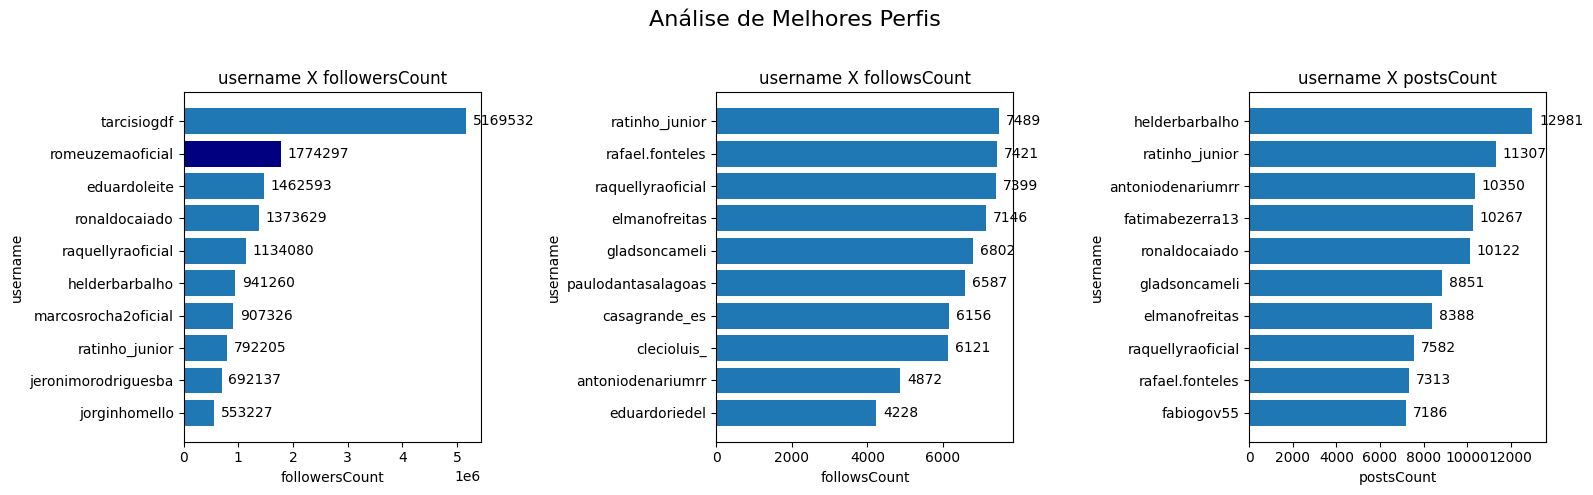

Figura 'graficos_de_barras_destacados.png' gerada com sucesso.


(<_io.BytesIO at 0x196321d6a70>,
 {'followers':               username  followersCount
  0        jorginhomello          553227
  1  jeronimorodriguesba          692137
  2       ratinho_junior          792205
  3  marcosrocha2oficial          907326
  4       helderbarbalho          941260
  5    raquellyraoficial         1134080
  6        ronaldocaiado         1373629
  7         eduardoleite         1462593
  8     romeuzemaoficial         1774297
  9          tarcisiogdf         5169532,
  'follows':              username  followsCount
  0       eduardoriedel          4228
  1   antoniodenariumrr          4872
  2         clecioluis_          6121
  3       casagrande_es          6156
  4  paulodantasalagoas          6587
  5       gladsoncameli          6802
  6       elmanofreitas          7146
  7   raquellyraoficial          7399
  8     rafael.fonteles          7421
  9      ratinho_junior          7489,
  'posts_count':             username  postsCount
  0         fabiogov55

In [ ]:
def plotarFigura1(client_name):
    
    """ 

    def tratarDados():
    
        # Tratar Dados
        posts_df['data_hora'] = pd.to_datetime(posts_df['timestamp'])

        posts_df_gruped = posts_df.groupby(['ownerId', 'ownerUsername']).agg(
        commentsSum=('commentsCount', 'sum'),
        likesSum=('likesCount', 'sum'),
        minData=('data_hora', 'min'),
        maxData=('data_hora', 'max'),
        count=('ownerId', 'count')
        ).reset_index()

        profile_df_posts_int = pd.merge(profile_df, posts_df_gruped, left_on='id', right_on='ownerId', how='left').drop(['ownerId'], axis=1)
        profile_df_posts_int['TOTAL ENGAJAMENTO'] = (profile_df_posts_int['commentsSum'] + profile_df_posts_int['likesSum'])
        profile_df_posts_int[r'% ENGAJAMENTO'] =  profile_df_posts_int['TOTAL ENGAJAMENTO'] / profile_df_posts_int['followersCount']
        profile_df_posts_int['RECENCIA'] = 1 / ((profile_df_posts_int['maxData'].max() - profile_df_posts_int['maxData']).dt.days + 1)
        profile_df_posts_int['FREQUENCIA'] = profile_df_posts_int['count'] / ((profile_df_posts_int['maxData'] - profile_df_posts_int['minData']).dt.days + 1)

        return profile_df_posts_int
        
    profile_df_posts_int = tratarDados()
    
    """   
    
    def plotarBarraMax(client_name, x_col, y_col, ax1):
        
        # Calcular Estatísticas
        top_10 = profile_df_posts_int.groupby([y_col])[x_col].max().sort_values(ascending=True).tail(10).reset_index()
        
        # --- 4. Configuração do Primeiro Gráfico (Superior) ---
        # Preparar cores e rótulos para o primeiro gráfico
        cores1 = ['#1f77b4'] * 10 # Cor padrão para as barras
        
        if client_name in list(top_10['username']):
            try:
                # Encontra a posição (índice) do elemento X nos dados ordenados
                indice_x = top_10.loc[top_10[y_col] == client_name].index[0]
                cores1[indice_x] = '#000080' # Cor de destaque para o elemento X
                print('Cor alterada com Sucesso!')
            except KeyError:
                indice_x = -1 # Trata o caso do elemento não ser encontrado

        # Plota o gráfico de barras
        barras1 = ax1.barh(top_10[y_col], top_10[x_col], color=cores1)
        ax1.bar_label(barras1, fmt='%d', padding=5)
        ax1.set_title(f'{y_col} X {x_col}')
        ax1.set_xlabel(x_col)
        ax1.set_ylabel(y_col)

        return top_10

    # --- 3. Criação da Figura e dos Gráficos (Subplots) ---
    # Cria a figura com 2 linhas e 1 coluna de gráficos
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Análise de Melhores Perfis', fontsize=16)
      
    top_10_followers = plotarBarraMax(client_name, 'followersCount', 'username', ax1)
    top_10_follows = plotarBarraMax(client_name, 'followsCount', 'username', ax2)
    top_10_posts_count = plotarBarraMax(client_name, 'postsCount', 'username', ax3)

    dataframes = {
                    "followers": top_10_followers,
                    "follows": top_10_follows,
                    "posts_count": top_10_posts_count
    }

    # --- 6. Finalização e Exibição/Salvamento da Figura ---
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para evitar sobreposição

    buffer = io.BytesIO() 
    
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)

    # Para exibir a figura diretamente (se estiver em um ambiente interativo como Jupyter)
    plt.show()

    print("Figura 'graficos_de_barras_destacados.png' gerada com sucesso.")

    return buffer, dataframes

plotarFigura1('romeuzemaoficial')

Cor alterada com Sucesso!


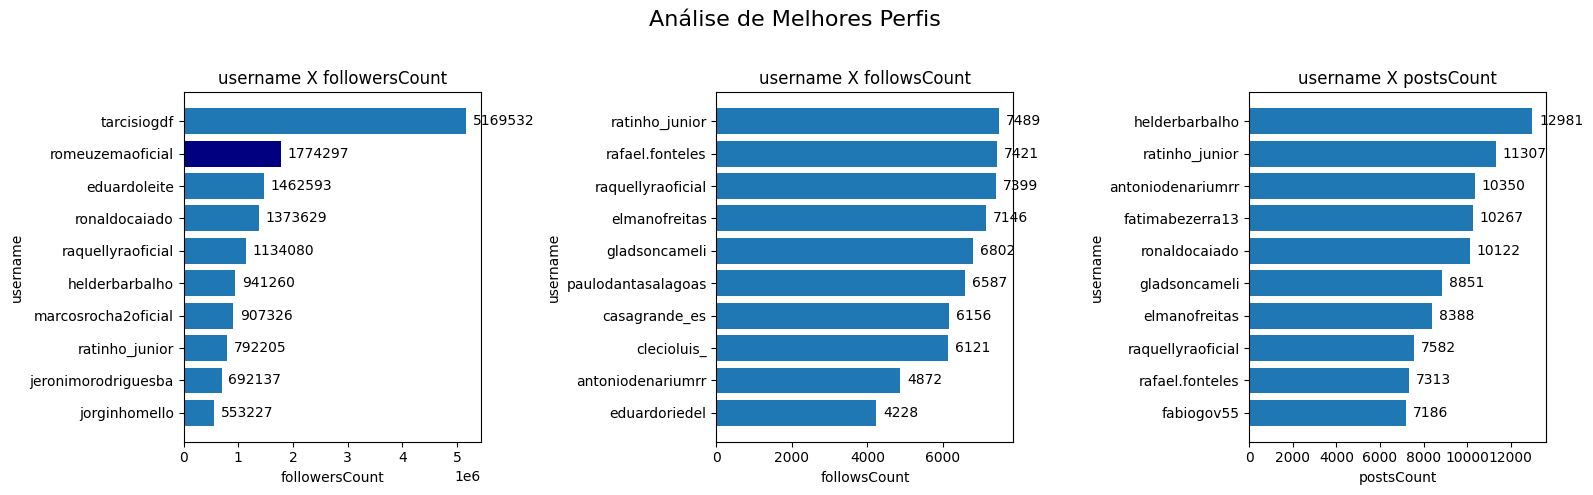

Figura 'graficos_de_barras_destacados.png' gerada com sucesso.


(<_io.BytesIO at 0x196321d6a70>,
 {'followers':               username  followersCount
  0        jorginhomello          553227
  1  jeronimorodriguesba          692137
  2       ratinho_junior          792205
  3  marcosrocha2oficial          907326
  4       helderbarbalho          941260
  5    raquellyraoficial         1134080
  6        ronaldocaiado         1373629
  7         eduardoleite         1462593
  8     romeuzemaoficial         1774297
  9          tarcisiogdf         5169532,
  'follows':              username  followsCount
  0       eduardoriedel          4228
  1   antoniodenariumrr          4872
  2         clecioluis_          6121
  3       casagrande_es          6156
  4  paulodantasalagoas          6587
  5       gladsoncameli          6802
  6       elmanofreitas          7146
  7   raquellyraoficial          7399
  8     rafael.fonteles          7421
  9      ratinho_junior          7489,
  'posts_count':             username  postsCount
  0         fabiogov55

In [ ]:
def plotarFigura1(client_name):
    
    """ 

    def tratarDados():
    
        # Tratar Dados
        posts_df['data_hora'] = pd.to_datetime(posts_df['timestamp'])

        posts_df_gruped = posts_df.groupby(['ownerId', 'ownerUsername']).agg(
        commentsSum=('commentsCount', 'sum'),
        likesSum=('likesCount', 'sum'),
        minData=('data_hora', 'min'),
        maxData=('data_hora', 'max'),
        count=('ownerId', 'count')
        ).reset_index()

        profile_df_posts_int = pd.merge(profile_df, posts_df_gruped, left_on='id', right_on='ownerId', how='left').drop(['ownerId'], axis=1)
        profile_df_posts_int['TOTAL ENGAJAMENTO'] = (profile_df_posts_int['commentsSum'] + profile_df_posts_int['likesSum'])
        profile_df_posts_int[r'% ENGAJAMENTO'] =  profile_df_posts_int['TOTAL ENGAJAMENTO'] / profile_df_posts_int['followersCount']
        profile_df_posts_int['RECENCIA'] = 1 / ((profile_df_posts_int['maxData'].max() - profile_df_posts_int['maxData']).dt.days + 1)
        profile_df_posts_int['FREQUENCIA'] = profile_df_posts_int['count'] / ((profile_df_posts_int['maxData'] - profile_df_posts_int['minData']).dt.days + 1)

        return profile_df_posts_int
        
    profile_df_posts_int = tratarDados()
    
    """   
    
    def plotarBarraMax(client_name, x_col, y_col, ax1):
        
        # Calcular Estatísticas
        top_10 = profile_df_posts_int.groupby([y_col])[x_col].max().sort_values(ascending=True).tail(10).reset_index()
        
        # --- 4. Configuração do Primeiro Gráfico (Superior) ---
        # Preparar cores e rótulos para o primeiro gráfico
        cores1 = ['#1f77b4'] * 10 # Cor padrão para as barras
        
        if client_name in list(top_10['username']):
            try:
                # Encontra a posição (índice) do elemento X nos dados ordenados
                indice_x = top_10.loc[top_10[y_col] == client_name].index[0]
                cores1[indice_x] = '#000080' # Cor de destaque para o elemento X
                print('Cor alterada com Sucesso!')
            except KeyError:
                indice_x = -1 # Trata o caso do elemento não ser encontrado

        # Plota o gráfico de barras
        barras1 = ax1.barh(top_10[y_col], top_10[x_col], color=cores1)
        ax1.bar_label(barras1, fmt='%d', padding=5)
        ax1.set_title(f'{y_col} X {x_col}')
        ax1.set_xlabel(x_col)
        ax1.set_ylabel(y_col)

        return top_10

    # --- 3. Criação da Figura e dos Gráficos (Subplots) ---
    # Cria a figura com 2 linhas e 1 coluna de gráficos
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Análise de Melhores Perfis', fontsize=16)
      
    top_10_followers = plotarBarraMax(client_name, 'followersCount', 'username', ax1)
    top_10_follows = plotarBarraMax(client_name, 'followsCount', 'username', ax2)
    top_10_posts_count = plotarBarraMax(client_name, 'postsCount', 'username', ax3)

    dataframes = {
                    "followers": top_10_followers,
                    "follows": top_10_follows,
                    "posts_count": top_10_posts_count
    }

    # --- 6. Finalização e Exibição/Salvamento da Figura ---
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para evitar sobreposição

    buffer = io.BytesIO() 
    
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)

    # Para exibir a figura diretamente (se estiver em um ambiente interativo como Jupyter)
    plt.show()

    print("Figura 'graficos_de_barras_destacados.png' gerada com sucesso.")

    return buffer, dataframes

plotarFigura1('romeuzemaoficial')

## Figura 2

Iniciando otimização de hiperparâmetros...
100%|██████████| 100/100 [00:00<00:00, 234.82trial/s, best loss: -0.44414421855542563]

Processo de AutoCluster concluído.
Melhor algoritmo: DBSCAN
Melhores parâmetros: {'eps': 0.5050887052680685, 'min_samples': 3}
Melhor pontuação CVI combinada: 0.6061


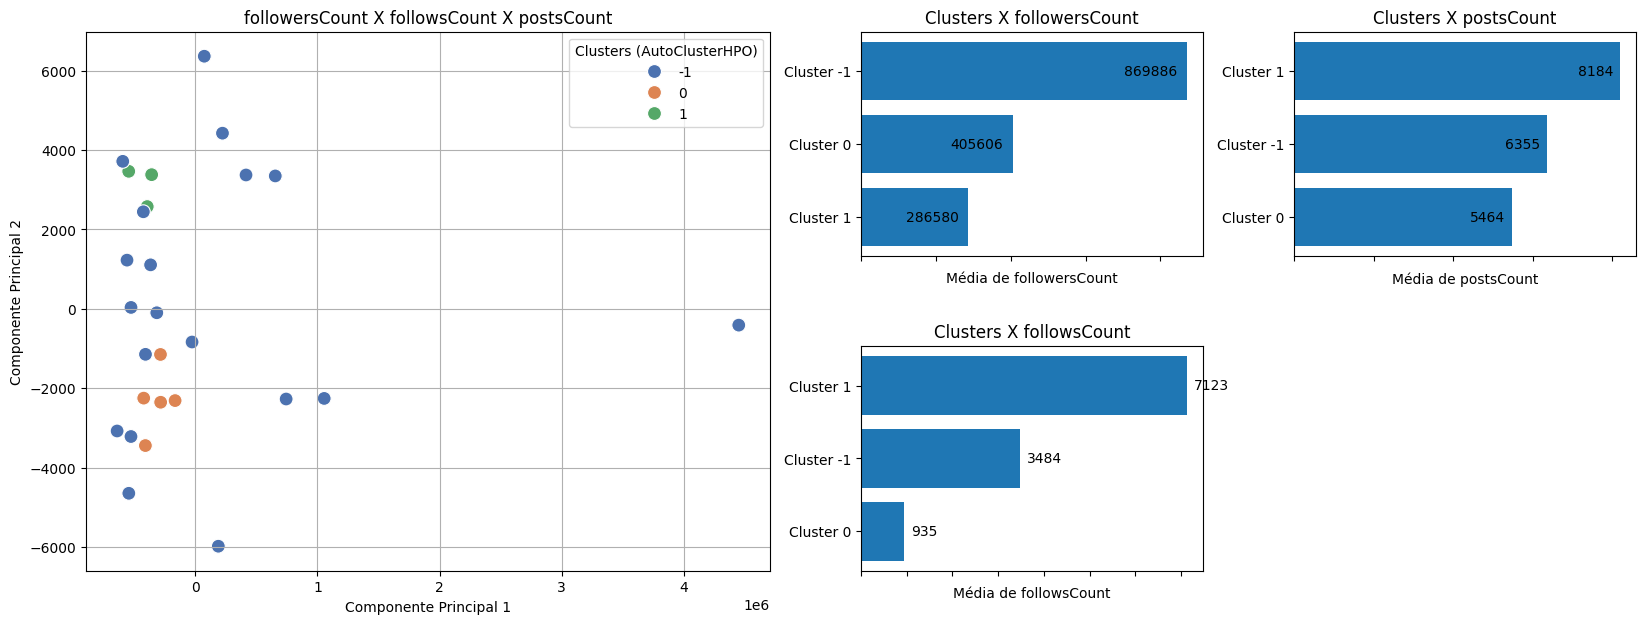

(<_io.BytesIO at 0x25c323fc0e0>,
 {'df_original_copy':         pca_x    pca_y  Clusters (AutoClusterHPO)
  0   -26960.01  -836.20                         -1
  1  -527077.57 -3216.76                         -1
  2  -559658.13  1226.38                         -1
  3   654530.56  3347.30                         -1
  4  -545582.49  3464.09                          1
  5  -284095.99 -2353.61                          0
  6  -408329.30 -1146.38                         -1
  7  -315748.77   -99.53                         -1
  8  -366557.10  1107.41                         -1
  9  -357895.63  3379.39                          1
  10 -640730.23 -3077.51                         -1
  11  222162.13  4424.41                         -1
  12 -422800.69 -2249.74                          0
  13 -409082.26 -3444.65                          0
  14 1055202.09 -2257.19                         -1
  15  414979.22  3371.47                         -1
  16 -394081.41  2575.38                          1
  17 -28559

In [ ]:
def plotarFigura2(profile_df, posts_df):
    
    def tratarDados():
        
        # LINHA CRÍTICA A SER ADICIONADA:
        # Carregue o arquivo JSON para um DataFrame

        # Tratar Dados
        posts_df['data_hora'] = pd.to_datetime(posts_df['timestamp'])

        posts_df_gruped = posts_df.groupby(['ownerId', 'ownerUsername']).agg(
        commentsSum=('commentsCount', 'sum'),
        likesSum=('likesCount', 'sum'),
        minData=('data_hora', 'min'),
        maxData=('data_hora', 'max'),
        count=('ownerId', 'count')
        ).reset_index()

        profile_df_posts_int = pd.merge(profile_df, posts_df_gruped, left_on='id', right_on='ownerId', how='left').drop(['ownerId'], axis=1)
        profile_df_posts_int['TOTAL ENGAJAMENTO'] = (profile_df_posts_int['commentsSum'] + profile_df_posts_int['likesSum'])
        profile_df_posts_int[r'% ENGAJAMENTO'] =  profile_df_posts_int['TOTAL ENGAJAMENTO'] / profile_df_posts_int['followersCount']
        profile_df_posts_int['RECENCIA'] = 1 / ((profile_df_posts_int['maxData'].max() - profile_df_posts_int['maxData']).dt.days + 1)
        profile_df_posts_int['FREQUENCIA'] = profile_df_posts_int['count'] / ((profile_df_posts_int['maxData'] - profile_df_posts_int['minData']).dt.days + 1)
        
        return profile_df_posts_int
    
    def plotarFiguraNColsPCA(df_original, df_cluster, fig):
            
        def plotarDispersao(fig):
            
            cluster_columns = [column for column in df_cluster.columns if column != 'Clusters (AutoClusterHPO)']
            
            # Redução de dimensionalidade com PCA
            pca = PCA(n_components=2)
            df_pca = pca.fit_transform(df_original[cluster_columns])
            df_original_copy['pca_x'] = df_pca[:, 0]
            df_original_copy['pca_y'] = df_pca[:, 1]
                
            # Visualização dos clusters com PCA
            axes_gs_principal = fig.add_subplot(gs_principal[0])
            sns.scatterplot(data=df_original_copy, x='pca_x', y='pca_y', hue='Clusters (AutoClusterHPO)', palette='deep', s=100, ax=axes_gs_principal) 
            axes_gs_principal.set_title(f" X ".join(cluster_columns))
            axes_gs_principal.set_xlabel('Componente Principal 1')
            axes_gs_principal.set_ylabel('Componente Principal 2')
            axes_gs_principal.grid(True)

            return df_original_copy[['pca_x', 'pca_y', 'Clusters (AutoClusterHPO)']]
        
        def plotarBarras(fig):
            
            df_original['Clusters (AutoClusterHPO)'] = 'Cluster ' + df_original['Clusters (AutoClusterHPO)'].astype(str)
                
            media_1 = df_original.groupby('Clusters (AutoClusterHPO)')[str(df_cluster.columns[0])].mean().reset_index().sort_values(by=str(df_cluster.columns[0]), ascending=True)
            media_2 = df_original.groupby('Clusters (AutoClusterHPO)')[str(df_cluster.columns[1])].mean().reset_index().sort_values(by=str(df_cluster.columns[1]), ascending=True)
            media_3 = df_original.groupby('Clusters (AutoClusterHPO)')[str(df_cluster.columns[2])].mean().reset_index().sort_values(by=str(df_cluster.columns[2]), ascending=True)
                
                
            # Plotar Gráfico de Barra 1
            axes_gs_0 = fig.add_subplot(gs[0])
            axes_gs_0.set_title(f'Clusters X {str(df_cluster.columns[0])}')
            barras1 = axes_gs_0.barh(media_1['Clusters (AutoClusterHPO)'], media_1[str(df_cluster.columns[0])])
            axes_gs_0.bar_label(barras1, fmt='%d', padding=-45)
            axes_gs_0.set_xticklabels([])
            axes_gs_0.set_xlabel(f'Média de {str(df_cluster.columns[0])}')

            # Plotar Gráfico de Barra 2
            axes_gs_1 = fig.add_subplot(gs[1])
            axes_gs_1.set_title(f'Clusters X {str(df_cluster.columns[1])}')
            barras2 = axes_gs_1.barh(media_2['Clusters (AutoClusterHPO)'], media_2[str(df_cluster.columns[1])])
            axes_gs_1.bar_label(barras2, fmt='%d', padding=5)
            axes_gs_1.set_xticklabels([])
            axes_gs_1.set_xlabel(f'Média de {str(df_cluster.columns[1])}')
                
            # Plotar Gráfico de Barra 3
            axes_gs1_0 = fig.add_subplot(gs1[0])
            axes_gs1_0.set_title(f'Clusters X {str(df_cluster.columns[2])}')
            barras3 = axes_gs1_0.barh(media_3['Clusters (AutoClusterHPO)'], media_3[str(df_cluster.columns[2])])
            axes_gs1_0.bar_label(barras3, fmt='%d', padding=-30)
            axes_gs1_0.set_xticklabels([])
            axes_gs1_0.set_xlabel(f'Média de {str(df_cluster.columns[2])}')

            return media_1, media_2, media_3
    
        # Copiar df original
        df_original_copy = df_original.copy()
            
        gs_principal = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[2, 1, 1], wspace=0.2)
        gs = gs_principal[1].subgridspec(2, 1, hspace=0.4)
        gs1 = gs_principal[2].subgridspec(2, 1, hspace=0.4)
            
        df_original_copy = plotarDispersao(fig)
        media_1, media_2, media_3 = plotarBarras(fig)

        dataframes = {'df_original_copy' : df_original_copy, 
                    'df_media_1' : media_1,
                    'df_media_2' : media_2,
                    'df_media_3' : media_3}

        return dataframes

    profile_df_posts_int = tratarDados()
    
    # Separar Bases 
    df_original = profile_df_posts_int
    df_cluster = profile_df_posts_int[['followersCount', 'followsCount', 'postsCount']].copy()

    # Inicializar e aplicar o AutoCluster
    autocluster_tool = AutoClusterHPO(max_evals_per_algo=100) 
    df_original['Clusters (AutoClusterHPO)'], model, config, score, algo_name = autocluster_tool.fit_predict(df_cluster)

    fig = plt.figure(figsize=(20, 7))
    
    dataframes = plotarFiguraNColsPCA(df_original, df_cluster, fig)

    # --- 6. Finalização e Exibição/Salvamento da Figura ---
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para evitar sobreposição

    buffer = io.BytesIO() 
        
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)
        
    plt.show()

    buffer.seek(0)

    return buffer, dataframes

    
    def tratarDados():
        
        # LINHA CRÍTICA A SER ADICIONADA:
        # Carregue o arquivo JSON para um DataFrame
        posts_df = pd.read_json("data/raw/post_data.json")

        # Tratar Dados
        posts_df['data_hora'] = pd.to_datetime(posts_df['timestamp'])

        posts_df_gruped = posts_df.groupby(['ownerId', 'ownerUsername']).agg(
        commentsSum=('commentsCount', 'sum'),
        likesSum=('likesCount', 'sum'),
        minData=('data_hora', 'min'),
        maxData=('data_hora', 'max'),
        count=('ownerId', 'count')
        ).reset_index()

        profile_df_posts_int = pd.merge(profile_df, posts_df_gruped, left_on='id', right_on='ownerId', how='left').drop(['ownerId'], axis=1)
        profile_df_posts_int['TOTAL ENGAJAMENTO'] = (profile_df_posts_int['commentsSum'] + profile_df_posts_int['likesSum'])
        profile_df_posts_int[r'% ENGAJAMENTO'] =  profile_df_posts_int['TOTAL ENGAJAMENTO'] / profile_df_posts_int['followersCount']
        profile_df_posts_int['RECENCIA'] = 1 / ((profile_df_posts_int['maxData'].max() - profile_df_posts_int['maxData']).dt.days + 1)
        profile_df_posts_int['FREQUENCIA'] = profile_df_posts_int['count'] / ((profile_df_posts_int['maxData'] - profile_df_posts_int['minData']).dt.days + 1)
        
        return profile_df_posts_int
    
    def plotarFiguraNColsPCA(df_original, df_cluster):
            
        def plotarDispersao():
            
            cluster_columns = [column for column in df_cluster.columns if column != 'Clusters (AutoClusterHPO)']
            
            # Redução de dimensionalidade com PCA
            pca = PCA(n_components=2)
            df_pca = pca.fit_transform(df_original[cluster_columns])
            df_original_copy['pca_x'] = df_pca[:, 0]
            df_original_copy['pca_y'] = df_pca[:, 1]
                
            # Visualização dos clusters com PCA
            axes_gs_principal = fig.add_subplot(gs_principal[0])
            plt.figure(figsize=(10, 7))
            sns.scatterplot(data=df_original_copy, x='pca_x', y='pca_y', hue='Clusters (AutoClusterHPO)', palette='deep', s=100, ax=axes_gs_principal) 
            axes_gs_principal.set_title(f" X ".join(cluster_columns))
            axes_gs_principal.set_xlabel('Componente Principal 1')
            axes_gs_principal.set_ylabel('Componente Principal 2')
            axes_gs_principal.grid(True)

            return df_original_copy[['pca_x', 'pca_y', 'Clusters (AutoClusterHPO)']]
        
        def plotarBarras():
            
            df_original['Clusters (AutoClusterHPO)'] = 'Cluster ' + df_original['Clusters (AutoClusterHPO)'].astype(str)
                
            media_1 = df_original.groupby('Clusters (AutoClusterHPO)')[str(df_cluster.columns[0])].mean().reset_index().sort_values(by=str(df_cluster.columns[0]), ascending=True)
            media_2 = df_original.groupby('Clusters (AutoClusterHPO)')[str(df_cluster.columns[1])].mean().reset_index().sort_values(by=str(df_cluster.columns[1]), ascending=True)
            media_3 = df_original.groupby('Clusters (AutoClusterHPO)')[str(df_cluster.columns[2])].mean().reset_index().sort_values(by=str(df_cluster.columns[2]), ascending=True)
                
                
            # Plotar Gráfico de Barra 1
            axes_gs_0 = fig.add_subplot(gs[0])
            axes_gs_0.set_title(f'Clusters X {str(df_cluster.columns[0])}')
            barras1 = axes_gs_0.barh(media_1['Clusters (AutoClusterHPO)'], media_1[str(df_cluster.columns[0])])
            axes_gs_0.bar_label(barras1, fmt='%d', padding=-45)
            axes_gs_0.set_xticklabels([])
            axes_gs_0.set_xlabel(f'Média de {str(df_cluster.columns[0])}')

            # Plotar Gráfico de Barra 2
            axes_gs_1 = fig.add_subplot(gs[1])
            axes_gs_1.set_title(f'Clusters X {str(df_cluster.columns[1])}')
            barras2 = axes_gs_1.barh(media_2['Clusters (AutoClusterHPO)'], media_2[str(df_cluster.columns[1])])
            axes_gs_1.bar_label(barras2, fmt='%d', padding=5)
            axes_gs_1.set_xticklabels([])
            axes_gs_1.set_xlabel(f'Média de {str(df_cluster.columns[1])}')
                
            # Plotar Gráfico de Barra 3
            axes_gs1_0 = fig.add_subplot(gs1[0])
            axes_gs1_0.set_title(f'Clusters X {str(df_cluster.columns[2])}')
            barras3 = axes_gs1_0.barh(media_3['Clusters (AutoClusterHPO)'], media_3[str(df_cluster.columns[2])])
            axes_gs1_0.bar_label(barras3, fmt='%d', padding=-30)
            axes_gs1_0.set_xticklabels([])
            axes_gs1_0.set_xlabel(f'Média de {str(df_cluster.columns[2])}')

            return media_1, media_2, media_3
    
        # Copiar df original
        df_original_copy = df_original.copy()
            
        fig = plt.figure(figsize=(20, 7))
        gs_principal = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[2, 1, 1], wspace=0.2)
        gs = gs_principal[1].subgridspec(2, 1, hspace=0.4)
        gs1 = gs_principal[2].subgridspec(2, 1, hspace=0.4)
                
        fig.suptitle(
            f'Resultados da Clusterização entre: {str(df_cluster.columns[1])} X {str(df_cluster.columns[0])} X {str(df_cluster.columns[2])}',   # O texto do título
            fontsize=20,                    # Define o tamanho da fonte para 20
            fontweight='medium',
            y=1.03               # Define o estilo da fonte como negrito
        )
            
        df_original_copy = plotarDispersao()
        media_1, media_2, media_3 = plotarBarras()

        dataframes = {'df_original_copy' : df_original_copy, 
                    'df_media_1' : media_1,
                    'df_media_2' : media_2,
                    'df_media_3' : media_3}

        # --- 6. Finalização e Exibição/Salvamento da Figura ---
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para evitar sobreposição

        buffer = io.BytesIO() 
        
        # Para salvar a figura em um arquivo
        plt.savefig(buffer, format='png', dpi=300)
        
        plt.show()

        return buffer, dataframes

    def clusterizar(df_cluster, df_original, pairplot=False):
        
        # Inicializar e aplicar o AutoCluster
        autocluster_tool = AutoClusterHPO(max_evals_per_algo=100) 
        df_original['Clusters (AutoClusterHPO)'], model, config, score, algo_name = autocluster_tool.fit_predict(df_cluster)
        
        # Passo 1: Guarde os nomes das colunas e o índice original
        original_columns = df_cluster.columns
        original_index = df_cluster.index
        
        # Passo 2: Escalar Dataframe
        scaler = StandardScaler()
        df_scaled_array = scaler.fit_transform(df_cluster)
        
        # Passo 3: Guadar valor novamente
        df_cluster = pd.DataFrame(df_scaled_array, index=original_index, columns=original_columns)
        df_cluster['Clusters (AutoClusterHPO)'] = df_original['Clusters (AutoClusterHPO)']
        
        stats_melted = pd.melt(df_original, id_vars=['Clusters (AutoClusterHPO)'], value_vars=df_cluster.columns, var_name='Variable', value_name='Value')
        df = stats_melted.groupby(['Clusters (AutoClusterHPO)', 'Variable']).describe().reset_index()

        return df_cluster, df_original, df, model, config, score, algo_name

    profile_df_posts_int = tratarDados()
    
    df_original = profile_df_posts_int
    df_cluster = profile_df_posts_int[['followersCount', 'followsCount', 'postsCount']].copy()

    df_cluster, df_original, df, model, config, score, algo_name = clusterizar(df_cluster, df_original, pairplot=False)
    buffer, dataframes = plotarFiguraNColsPCA(df_original, df_cluster)

    return buffer, dataframes

plotarFigura2(profile_df, posts_df)

## Figura 3

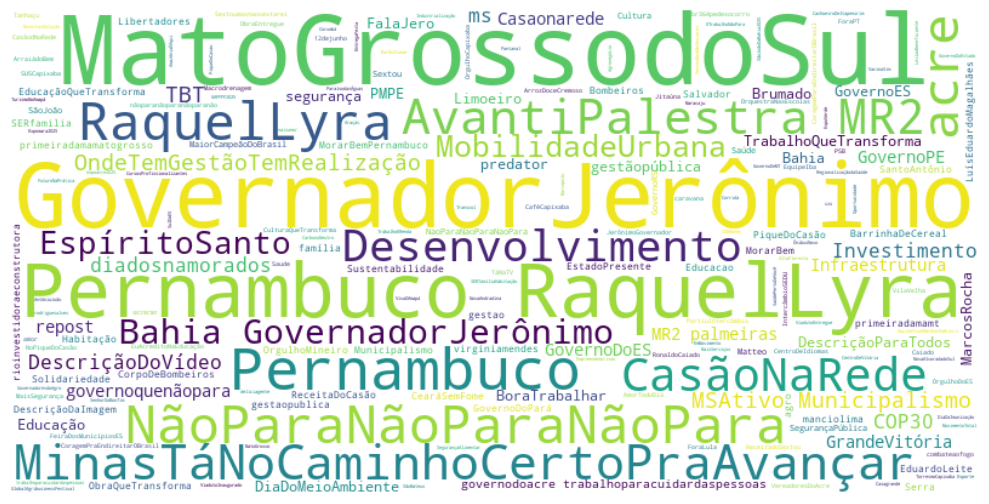

(<_io.BytesIO at 0x25c3432b150>,
 ['DescriçãoParaTodos:',
  'DescriçãoParaTodos:',
  'EquipeIba',
  'DescriçãoParaTodos:',
  'ReceitadoSextou',
  'ReceitaDoCasão',
  'CasãodNaRede',
  'ArrozDoceCremoso',
  'Saude',
  'Investimento',
  'SUSCapixaba',
  'Macrodrenagem',
  'VilaVelha',
  'Infraestrutura',
  'GovernoDoES',
  'ObraQueTransforma',
  'MaisSegurança',
  'PiqueDoCasão',
  'Sextoumasnaosextarei',
  'CasãoNaRede',
  'DiaDosNamorados',
  'AmorTodoDia',
  'CasãoNaRede',
  'IntercâmbioSEDU',
  'EducaçãoQueTransforma',
  'CentroDeIdiomas',
  'PartiuIntercâmbio',
  'Casaonarede',
  'EspíritoSanto',
  'ObraEntregue',
  'MobilidadeUrbana',
  'CasãoNaRede',
  'TrabalhoQueTransforma',
  'TáNaTV',
  'PSB',
  'NoPiqueDoCasão',
  'TrabalhoQueTransforma',
  'FeiraDosMunicípiosES',
  'OrgulhoCapixaba',
  'TrabalhoQueTransforma',
  'OrquestraNasEscolas',
  'CulturaQueTransforma',
  'GovernoDoES',
  'EstadoPresente',
  'governoquenãopara',
  'nãoparanãoparanãopara',
  'governoquenãopara',
  'não

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plotarFigura3():

    def plotarNuvemPalavras():

        lista_unica = []

        for sublista in posts_df['hashtags']:
            for item in sublista:
                lista_unica.append(item)

        # Seu texto aqui
        texto = " ".join(lista_unica)

        # Criar o objeto WordCloud
        nuvem_palavras = WordCloud(width=800, height=400, background_color="white").generate(texto)

        return nuvem_palavras, lista_unica

    nuvem_palavras, hashtags = plotarNuvemPalavras()

    # Exibir a imagem gerada
    plt.figure(figsize=(10, 10))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off") # Remove os eixos

    # --- 6. Finalização e Exibição/Salvamento da Figura ---
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para evitar sobreposição

    buffer = io.BytesIO() 
        
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)
        
    plt.show()

    buffer.seek(0)

    return buffer, hashtags 

plotarFigura3()

In [ ]:
lista_unica = []

for sublista in posts_df['hashtags']:
    for item in sublista:
        lista_unica.append(item)

pd.DataFrame(lista_unica).value_counts()


0                 
GovernadorJerônimo    28
Pernambuco            28
RaquelLyra            25
MatoGrossodoSul       14
MR2                    9
                      ..
Bahia,                 1
Caiado                 1
BandTV                 1
BarDoItamar            1
50ºSergipeÉAqui        1
Name: count, Length: 396, dtype: int64

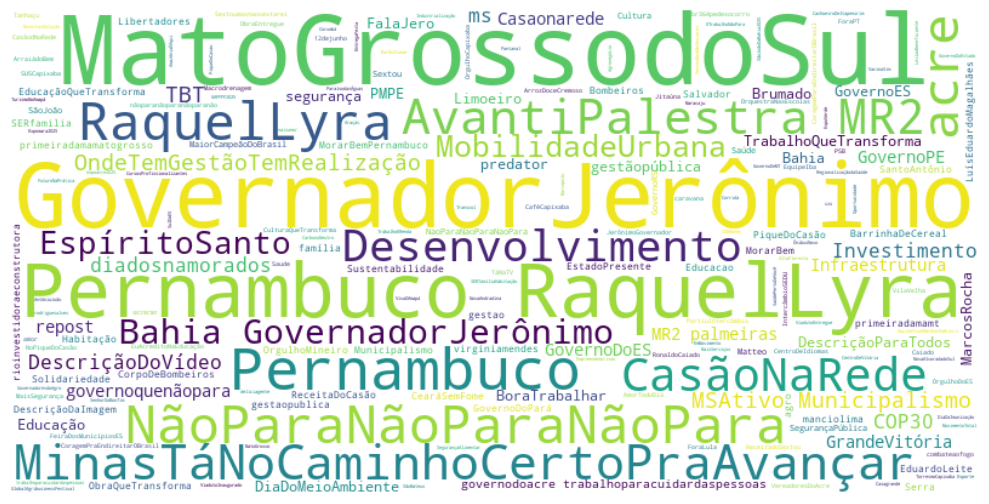

(<_io.BytesIO at 0x25c3432b150>,
 ['DescriçãoParaTodos:',
  'DescriçãoParaTodos:',
  'EquipeIba',
  'DescriçãoParaTodos:',
  'ReceitadoSextou',
  'ReceitaDoCasão',
  'CasãodNaRede',
  'ArrozDoceCremoso',
  'Saude',
  'Investimento',
  'SUSCapixaba',
  'Macrodrenagem',
  'VilaVelha',
  'Infraestrutura',
  'GovernoDoES',
  'ObraQueTransforma',
  'MaisSegurança',
  'PiqueDoCasão',
  'Sextoumasnaosextarei',
  'CasãoNaRede',
  'DiaDosNamorados',
  'AmorTodoDia',
  'CasãoNaRede',
  'IntercâmbioSEDU',
  'EducaçãoQueTransforma',
  'CentroDeIdiomas',
  'PartiuIntercâmbio',
  'Casaonarede',
  'EspíritoSanto',
  'ObraEntregue',
  'MobilidadeUrbana',
  'CasãoNaRede',
  'TrabalhoQueTransforma',
  'TáNaTV',
  'PSB',
  'NoPiqueDoCasão',
  'TrabalhoQueTransforma',
  'FeiraDosMunicípiosES',
  'OrgulhoCapixaba',
  'TrabalhoQueTransforma',
  'OrquestraNasEscolas',
  'CulturaQueTransforma',
  'GovernoDoES',
  'EstadoPresente',
  'governoquenãopara',
  'nãoparanãoparanãopara',
  'governoquenãopara',
  'não

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plotarFigura3():

    def plotarNuvemPalavras():

        lista_unica = []

        for sublista in posts_df['hashtags']:
            for item in sublista:
                lista_unica.append(item)

        # Seu texto aqui
        texto = " ".join(lista_unica)

        # Criar o objeto WordCloud
        nuvem_palavras = WordCloud(width=800, height=400, background_color="white").generate(texto)

        return nuvem_palavras, lista_unica

    nuvem_palavras, hashtags = plotarNuvemPalavras()

    # Exibir a imagem gerada
    plt.figure(figsize=(10, 10))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off") # Remove os eixos

    # --- 6. Finalização e Exibição/Salvamento da Figura ---
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para evitar sobreposição

    buffer = io.BytesIO() 
        
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)
        
    plt.show()

    buffer.seek(0)

    return buffer, hashtags 

plotarFigura3()

In [ ]:
lista_unica = []

for sublista in posts_df['hashtags']:
    for item in sublista:
        lista_unica.append(item)

pd.DataFrame(lista_unica).value_counts()


0                 
GovernadorJerônimo    28
Pernambuco            28
RaquelLyra            25
MatoGrossodoSul       14
MR2                    9
                      ..
Bahia,                 1
Caiado                 1
BandTV                 1
BarDoItamar            1
50ºSergipeÉAqui        1
Name: count, Length: 396, dtype: int64

## Figura 4

In [12]:
def Secao_2_2_Figura4(client_name, profile_df, posts_df):

    def tratarDados():

        # Tratar Dados
        posts_df['data_hora'] = pd.to_datetime(posts_df['timestamp'])

        posts_df_gruped = posts_df.groupby(['ownerId', 'ownerUsername']).agg(
        commentsSum=('commentsCount', 'sum'),
        likesSum=('likesCount', 'sum'),
        minData=('data_hora', 'min'),
        maxData=('data_hora', 'max'),
        count=('ownerId', 'count')
        ).reset_index()

        df_profiles_posts_int = pd.merge(profile_df, posts_df_gruped, left_on='id', right_on='ownerId', how='left').drop(['ownerId'], axis=1)
        df_profiles_posts_int['TOTAL ENGAJAMENTO'] = (df_profiles_posts_int['commentsSum'] + df_profiles_posts_int['likesSum'])
        df_profiles_posts_int[r'% ENGAJAMENTO'] =  df_profiles_posts_int['TOTAL ENGAJAMENTO'] / df_profiles_posts_int['followersCount']
        df_profiles_posts_int['RECENCIA'] = 1 / ((df_profiles_posts_int['maxData'].max() - df_profiles_posts_int['maxData']).dt.days + 1)
        df_profiles_posts_int['FREQUENCIA'] = df_profiles_posts_int['count'] / ((df_profiles_posts_int['maxData'] - df_profiles_posts_int['minData']).dt.days + 1)
        
        return df_profiles_posts_int
       
    def plotarBarraSum(client_name, df, x_col, y_col, ax1, fmt):
        
        # Calcular Estatísticas
        top_10 = df.groupby([y_col])[x_col].sum().sort_values(ascending=True).tail(10).reset_index()
        
        # --- 4. Configuração do Primeiro Gráfico (Superior) ---
        # Preparar cores e rótulos para o primeiro gráfico
        cores1 = ['#1f77b4'] * 10 # Cor padrão para as barras
        
        if client_name in list(top_10[y_col]):
            try:
                # Encontra a posição (índice) do elemento X nos dados ordenados
                indice_x = top_10.loc[top_10[y_col] == client_name].index[0]
                cores1[indice_x] = '#000080' # Cor de destaque para o elemento X
                print('Cor alterada com Sucesso!')
            except KeyError:
                indice_x = -1 # Trata o caso do elemento não ser encontrado

        # Plota o gráfico de barras
        barras1 = ax1.barh(top_10[y_col], top_10[x_col], color=cores1)
        ax1.bar_label(barras1, fmt=fmt, padding=5)
        ax1.set_title(f'{y_col} X {x_col}')
        ax1.set_xlabel(x_col)
        ax1.set_ylabel(y_col)

        return top_10

    # --- 3. Criação da Figura e dos Gráficos (Subplots) ---
    # Cria a figura com 2 linhas e 1 coluna de gráficos
    fig, axes = plt.subplots(2, 3, figsize=(16, 5))

    df_profiles_posts_int = tratarDados()

    posts_df['TOTAL ENGAJAMENTO'] = posts_df['likesCount'] + posts_df['commentsCount'] 
      
    top_10_followers = plotarBarraSum(client_name, df_profiles_posts_int, 'likesSum', 'username', axes[0, 0], '%d')
    top_10_follows = plotarBarraSum(client_name, df_profiles_posts_int, 'commentsSum', 'username', axes[0, 1], '%d')
    top_10_posts_count = plotarBarraSum(client_name, df_profiles_posts_int, '% ENGAJAMENTO', 'username', axes[0, 2], '%.2f')
    top_10_followers = plotarBarraSum(client_name, posts_df, 'likesCount', 'shortCode', axes[1, 0], '%d')
    top_10_follows = plotarBarraSum(client_name, posts_df, 'commentsCount', 'shortCode', axes[1, 1], '%d')
    top_10_posts_count = plotarBarraSum(client_name, posts_df, 'TOTAL ENGAJAMENTO', 'shortCode', axes[1, 2], '%d')

    dataframes = {
                    "followers": top_10_followers,
                    "follows": top_10_follows,
                    "posts_count": top_10_posts_count
    }

    # --- 6. Finalização e Exibição/Salvamento da Figura ---
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para evitar sobreposição

    buffer = io.BytesIO() 
    
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)

    # Para exibir a figura diretamente (se estiver em um ambiente interativo como Jupyter)
    plt.show()

    buffer.seek(0)

    print("Figura 'graficos_de_barras_destacados.png' gerada com sucesso.")

    return buffer, dataframes


Cor alterada com Sucesso!
Cor alterada com Sucesso!
Cor alterada com Sucesso!


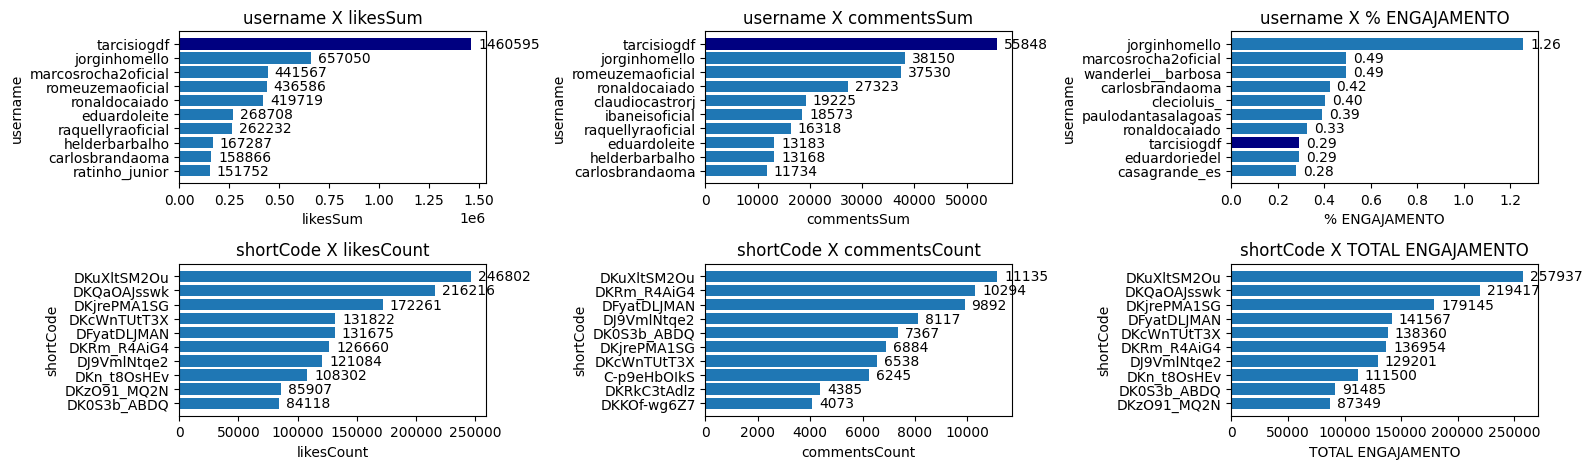

Figura 'graficos_de_barras_destacados.png' gerada com sucesso.


(<_io.BytesIO at 0x1fe35388a40>,
 {'followers':      shortCode  likesCount
  0  DK0S3b_ABDQ       84118
  1  DKzO91_MQ2N       85907
  2  DKn_t8OsHEv      108302
  3  DJ9VmlNtqe2      121084
  4  DKRm_R4AiG4      126660
  5  DFyatDLJMAN      131675
  6  DKcWnTUtT3X      131822
  7  DKjrePMA1SG      172261
  8  DKQaOAJsswk      216216
  9  DKuXltSM2Ou      246802,
  'follows':      shortCode  commentsCount
  0  DKKOf-wg6Z7           4073
  1  DKRkC3tAdlz           4385
  2  C-p9eHbOIkS           6245
  3  DKcWnTUtT3X           6538
  4  DKjrePMA1SG           6884
  5  DK0S3b_ABDQ           7367
  6  DJ9VmlNtqe2           8117
  7  DFyatDLJMAN           9892
  8  DKRm_R4AiG4          10294
  9  DKuXltSM2Ou          11135,
  'posts_count':      shortCode  TOTAL ENGAJAMENTO
  0  DKzO91_MQ2N              87349
  1  DK0S3b_ABDQ              91485
  2  DKn_t8OsHEv             111500
  3  DJ9VmlNtqe2             129201
  4  DKRm_R4AiG4             136954
  5  DKcWnTUtT3X             138360
  6

In [13]:
Secao_2_2_Figura4('tarcisiogdf', profile_df, posts_df)

## Figuras 5 e 6

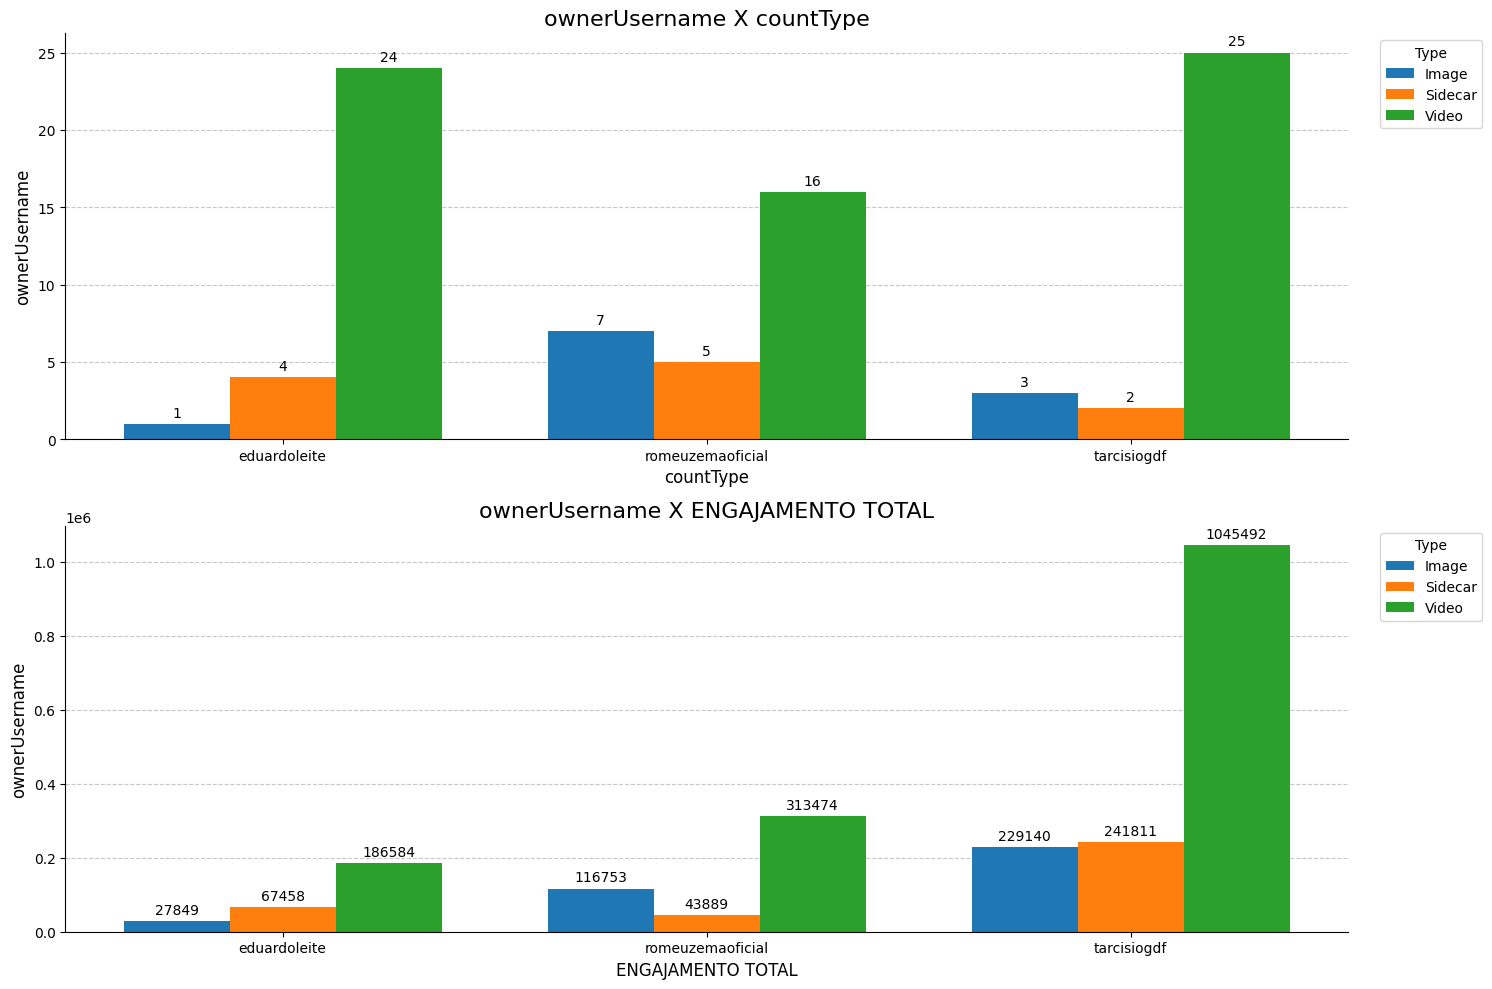

In [ ]:
def Secao_2_2_Figura5(posts_df, profile_df):

    def tratarDados(posts_df, profile_df):

        def filtro(usernames):
            return (posts_df['ownerUsername'] == usernames[0]) | (posts_df['ownerUsername'] == usernames[1]) | (posts_df['ownerUsername'] == usernames[2])

        filtro = filtro(['tarcisiogdf', 'romeuzemaoficial', 'eduardoleite'])

        posts_df_top_3 = posts_df[filtro]

        posts_df_top_3_merged = pd.merge(posts_df_top_3, profile_df, how='left', left_on='ownerUsername', right_on='username')

        posts_df_top_3_grouped = posts_df_top_3_merged.groupby(['ownerUsername', 'type']).agg(
            countType=('type', 'count'),
            followersMax=('followersCount', 'max'),
            likesSum=('likesCount', 'sum'),
            commentsSum=('commentsCount', 'sum')
        ).reset_index()

        posts_df_top_3_grouped['ENGAJAMENTO TOTAL'] = posts_df_top_3_grouped['commentsSum'] + posts_df_top_3_grouped['likesSum']

        dados_pivot_count = posts_df_top_3_grouped.pivot(index='ownerUsername', columns='type', values='countType')
        dados_pivot_total = posts_df_top_3_grouped.pivot(index='ownerUsername', columns='type', values='ENGAJAMENTO TOTAL')

        return dados_pivot_count, dados_pivot_total   

    def plotarBarrasAgrupadas(dados_pivot, x_column, y_column, group_column, ax):

        categorias_principais = dados_pivot.index
        subcategorias = dados_pivot.columns

        n_categorias_principais = len(categorias_principais)
        n_subcategorias = len(subcategorias)

        x = np.arange(n_categorias_principais)
        largura_barra = 0.25

        # 5. Loop para criar as barras para cada subcategoria (cada produto)
        for i, produto in enumerate(subcategorias):
            # Cálculo da posição de cada barra dentro do grupo.
            # O cálculo desloca cada conjunto de barras em relação ao centro do grupo (x).
            # O objetivo é centralizar o cluster de barras em torno do tick do eixo X.
            posicao = x - (largura_barra * n_subcategorias / 2) + (i * largura_barra) + (largura_barra / 2)
            
            # Pega os valores para o produto atual
            valores = dados_pivot[produto]
            
            # Cria as barras
            barra = ax.bar(posicao, valores, largura_barra, label=produto)

            # Adiciona os rótulos de valor no topo de cada barra para clareza
            ax.bar_label(barra, padding=3, fmt='%d') # fmt='%d' para mostrar como inteiro


        # 6. Adicionar rótulos, título, legenda e outros detalhes de formatação
        ax.set_xlabel(x_column, fontsize=12)
        ax.set_ylabel(y_column, fontsize=12)
        ax.set_title(f'{y_column} X {x_column}', fontsize=16)

        # Posiciona os rótulos da categoria principal (Anos) no centro dos grupos de barras
        ax.set_xticks(x)
        ax.set_xticklabels(categorias_principais)

        # Adiciona a legenda para identificar as cores das barras
        ax.legend(title=group_column, bbox_to_anchor=(1.02, 1), loc='upper left')

        # Adiciona uma grade horizontal para facilitar a leitura dos valores
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True) # Coloca a grade atrás das barras

        # Remove as bordas superior e direita para um visual mais limpo
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    dados_pivot_count, dados_pivot_total = tratarDados(posts_df, profile_df)

    dataframes = {'Type': dados_pivot_count,
                  'total': dados_pivot_total}
    
    # 4. Criar a figura e os eixos do gráfico
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    plotarBarrasAgrupadas(dados_pivot_count, 'countType', 'ownerUsername', 'Type', axes[0])
    plotarBarrasAgrupadas(dados_pivot_total, 'ENGAJAMENTO TOTAL', 'ownerUsername', 'Type', axes[1])

    # Ajusta o layout para garantir que nada (como a legenda) seja cortado
    fig.tight_layout()

    buffer = io.BytesIO() 
    
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)

    # 7. Exibir o gráfico
    plt.show()

    #buffer.seek(0)

    return buffer, dataframes

Secao_2_2_Figura5(posts_df, profile_df)

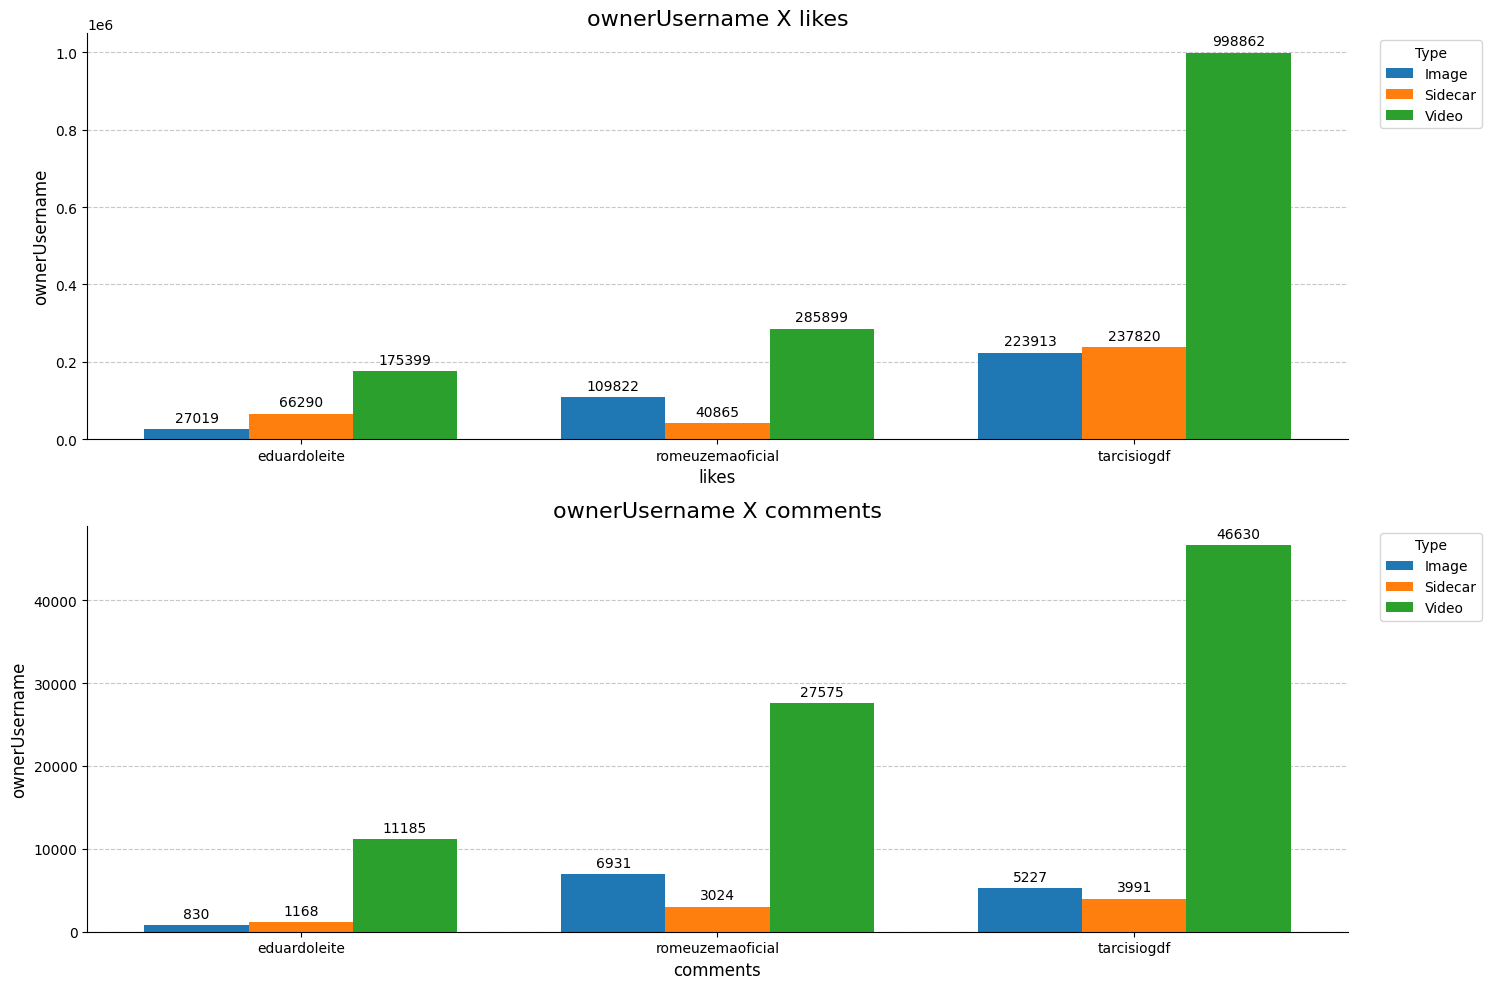

(<_io.BytesIO at 0x20b59064b80>,
 {'likes': type               Image  Sidecar   Video
  ownerUsername                            
  eduardoleite       27019    66290  175399
  romeuzemaoficial  109822    40865  285899
  tarcisiogdf       223913   237820  998862,
  'comments': type              Image  Sidecar  Video
  ownerUsername                          
  eduardoleite        830     1168  11185
  romeuzemaoficial   6931     3024  27575
  tarcisiogdf        5227     3991  46630})

In [35]:
def Secao_2_2_Figura6(posts_df, profile_df):

    def tratarDados(posts_df, profile_df):

        def filtro(usernames):
            return (posts_df['ownerUsername'] == usernames[0]) | (posts_df['ownerUsername'] == usernames[1]) | (posts_df['ownerUsername'] == usernames[2])

        filtro = filtro(['tarcisiogdf', 'romeuzemaoficial', 'eduardoleite'])

        posts_df_top_3 = posts_df[filtro]

        posts_df_top_3_merged = pd.merge(posts_df_top_3, profile_df, how='left', left_on='ownerUsername', right_on='username')

        posts_df_top_3_grouped = posts_df_top_3_merged.groupby(['ownerUsername', 'type']).agg(
            countType=('type', 'count'),
            followersMax=('followersCount', 'max'),
            likesSum=('likesCount', 'sum'),
            commentsSum=('commentsCount', 'sum')
        ).reset_index()

        dados_pivot_likes = posts_df_top_3_grouped.pivot(index='ownerUsername', columns='type', values='likesSum')
        dados_pivot_comments = posts_df_top_3_grouped.pivot(index='ownerUsername', columns='type', values='commentsSum')

        return dados_pivot_likes, dados_pivot_comments 

    def plotarBarrasAgrupadas(dados_pivot, x_column, y_column, group_column, ax):

        categorias_principais = dados_pivot.index
        subcategorias = dados_pivot.columns

        n_categorias_principais = len(categorias_principais)
        n_subcategorias = len(subcategorias)

        x = np.arange(n_categorias_principais)
        largura_barra = 0.25

        # 5. Loop para criar as barras para cada subcategoria (cada produto)
        for i, produto in enumerate(subcategorias):
            # Cálculo da posição de cada barra dentro do grupo.
            # O cálculo desloca cada conjunto de barras em relação ao centro do grupo (x).
            # O objetivo é centralizar o cluster de barras em torno do tick do eixo X.
            posicao = x - (largura_barra * n_subcategorias / 2) + (i * largura_barra) + (largura_barra / 2)
            
            # Pega os valores para o produto atual
            valores = dados_pivot[produto]
            
            # Cria as barras
            barra = ax.bar(posicao, valores, largura_barra, label=produto)

            # Adiciona os rótulos de valor no topo de cada barra para clareza
            ax.bar_label(barra, padding=3, fmt='%d') # fmt='%d' para mostrar como inteiro


        # 6. Adicionar rótulos, título, legenda e outros detalhes de formatação
        ax.set_xlabel(x_column, fontsize=12)
        ax.set_ylabel(y_column, fontsize=12)
        ax.set_title(f'{y_column} X {x_column}', fontsize=16)

        # Posiciona os rótulos da categoria principal (Anos) no centro dos grupos de barras
        ax.set_xticks(x)
        ax.set_xticklabels(categorias_principais)

        # Adiciona a legenda para identificar as cores das barras
        ax.legend(title=group_column, bbox_to_anchor=(1.02, 1), loc='upper left')

        # Adiciona uma grade horizontal para facilitar a leitura dos valores
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True) # Coloca a grade atrás das barras

        # Remove as bordas superior e direita para um visual mais limpo
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    dados_pivot_likes, dados_pivot_comments = tratarDados(posts_df, profile_df)

    dataframes = {'likes': dados_pivot_likes, 
                  'comments': dados_pivot_comments}
    
    # 4. Criar a figura e os eixos do gráfico
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    plotarBarrasAgrupadas(dados_pivot_likes, 'likes', 'ownerUsername', 'Type', axes[0])
    plotarBarrasAgrupadas(dados_pivot_comments, 'comments', 'ownerUsername', 'Type', axes[1])

    # Ajusta o layout para garantir que nada (como a legenda) seja cortado
    fig.tight_layout()

    buffer = io.BytesIO() 
    
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)

    # 7. Exibir o gráfico
    plt.show()

    #buffer.seek(0)

    return buffer, dataframes

Secao_2_2_Figura6(posts_df, profile_df)

## Figura 7

In [36]:
def Secao_2_3_Figura7(client_name, profile_df, posts_df):

    def tratarDados():

        #posts_df = pd.read_json("data/raw/post_data.json")
        #profile_df = pd.read_json("data/raw/profile_data.json")

        posts_df['DATA-HORA'] = pd.to_datetime(posts_df['timestamp'])
                
                # Usamos .dt.day_name() para obter o nome completo do dia da semana
        posts_df['DIA_DA_SEMANA'] = posts_df['DATA-HORA'].dt.day_name(locale='pt_BR')

                # --- Extraindo o Período do Dia ---
                # Vamos definir as faixas horárias para cada período
        def get_periodo_do_dia(hour):
            if 5 <= hour < 12:
                return 'Manhã'
            elif 12 <= hour < 18:
                return 'Tarde'
            elif 18 <= hour < 23:
                return 'Noite'
            else: # 23 to 5 (inclusive of 23, exclusive of 5)
                return 'Madrugada'

                # Aplicamos a função à hora de cada datetime
                # Primeiro, pegamos a hora, depois aplicamos a função
        posts_df['PERIODO_DO_DIA'] = posts_df['DATA-HORA'].dt.hour.apply(get_periodo_do_dia)

        periodo_df = posts_df.groupby(['PERIODO_DO_DIA']).size().sort_values(ascending=False)
        dias_df = posts_df.groupby(['DIA_DA_SEMANA']).size().sort_values(ascending=False)


        periodo_df = periodo_df.rename('Count')
        dias_df = dias_df.rename('Count')


                # Lista com a nova ordem desejada para as cidades
        ordem_periodos = ['Manhã', 'Tarde', 'Noite', 'Madrugada']
        ordem_dias = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

        periodo_df = periodo_df.reindex(ordem_periodos)
        dias_df = dias_df.reindex(ordem_dias)
        
        return periodo_df, dias_df 
       
    def plotarBarraSum(top_10, x_col, y_col, ax1, fmt):
        
        # --- 4. Configuração do Primeiro Gráfico (Superior) ---
        # Preparar cores e rótulos para o primeiro gráfico
        cores1 = ['#1f77b4'] * 10 # Cor padrão para as barras

        # Plota o gráfico de barras
        barras1 = ax1.bar(top_10.index, top_10.values, color=cores1)
        ax1.bar_label(barras1, fmt=fmt, padding=5)
        ax1.set_title(f'{y_col} X {x_col}')
        ax1.set_xlabel(x_col)
        ax1.set_ylabel(y_col)

        return top_10

    # --- 3. Criação da Figura e dos Gráficos (Subplots) ---
    # Cria a figura com 2 linhas e 1 coluna de gráficos
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 2]})

    periodo_df, dias_df = tratarDados()
      
    periodos_df = plotarBarraSum(periodo_df, 'Periodo do Dia', 'Count', axes[0], '%d')
    dias_df = plotarBarraSum(dias_df, 'Dia da Semana', 'Count', axes[1], '%d')

    dataframes = {
                    "periodos": periodos_df,
                    "dias": dias_df
    }

    # --- 6. Finalização e Exibição/Salvamento da Figura ---
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para evitar sobreposição

    buffer = io.BytesIO() 
    
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)

    # Para exibir a figura diretamente (se estiver em um ambiente interativo como Jupyter)
    plt.show()

    buffer.seek(0)

    print("Figura 'graficos_de_barras_destacados.png' gerada com sucesso.")

    return buffer, dataframes


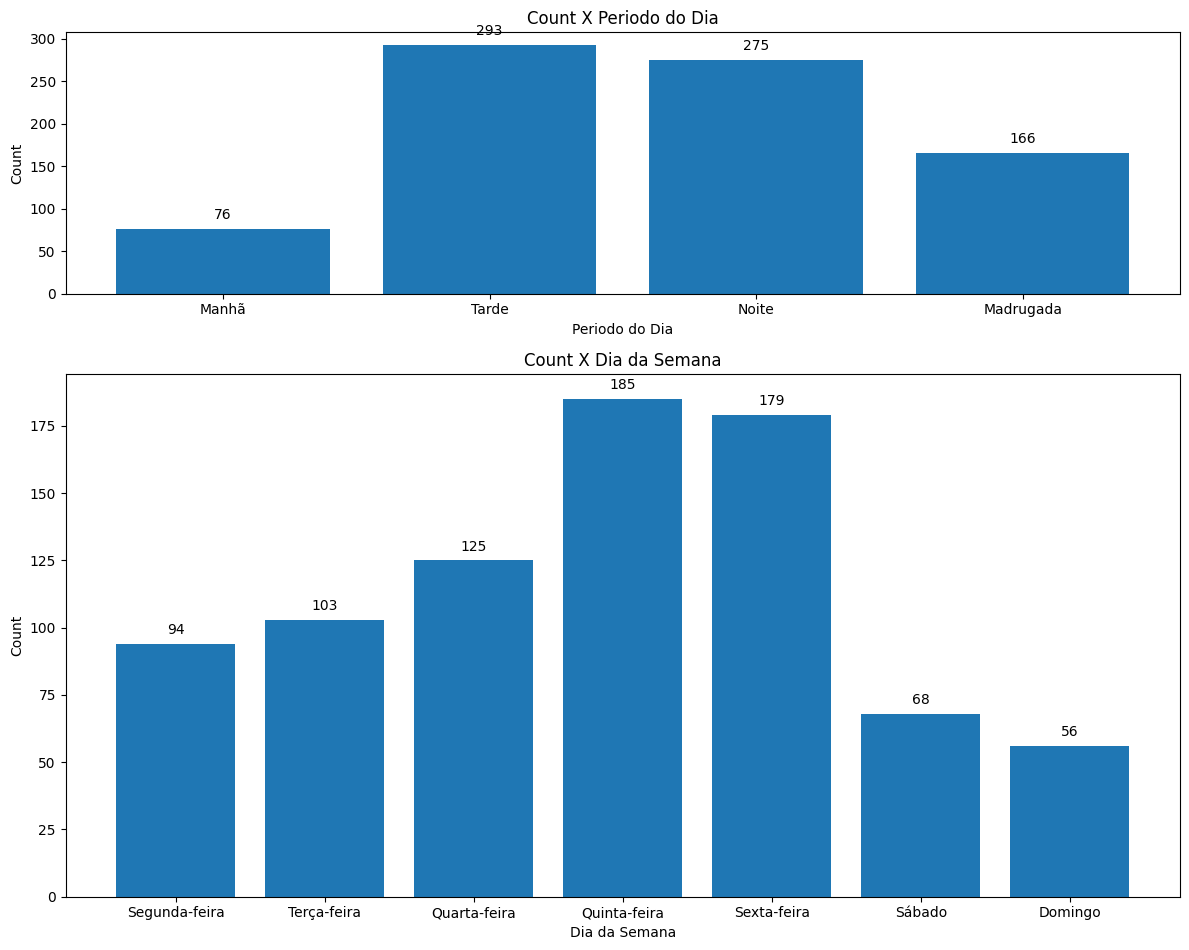

Figura 'graficos_de_barras_destacados.png' gerada com sucesso.


(<_io.BytesIO at 0x23ec7a31120>,
 {'periodos': PERIODO_DO_DIA
  Manhã         76
  Tarde        293
  Noite        275
  Madrugada    166
  Name: Count, dtype: int64,
  'dias': DIA_DA_SEMANA
  Segunda-feira     94
  Terça-feira      103
  Quarta-feira     125
  Quinta-feira     185
  Sexta-feira      179
  Sábado            68
  Domingo           56
  Name: Count, dtype: int64})

In [37]:
Secao_2_3_Figura7('tarcisiogdf', profile_df, posts_df)

## Figuras 8 e 9

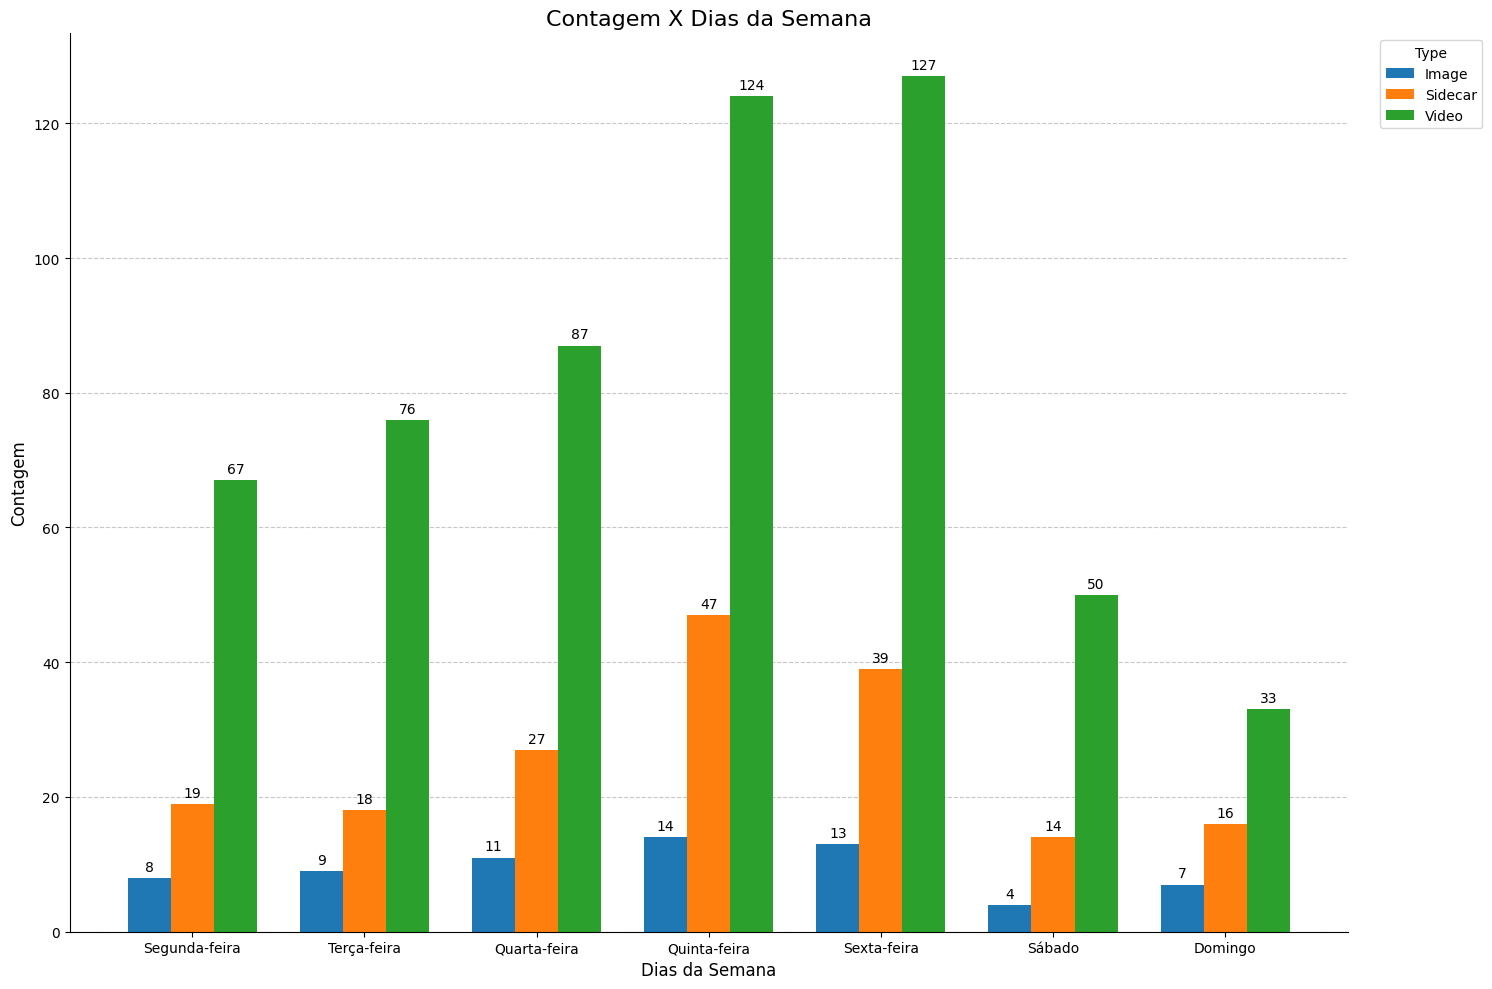

(<_io.BytesIO at 0x23ecde49760>,
 {'periodos': type            Image  Sidecar  Video
  PERIODO_DO_DIA                       
  Madrugada           9       56    101
  Manhã               6        8     62
  Noite              22       51    202
  Tarde              29       65    199,
  'dias': type           Image  Sidecar  Video
  DIA_DA_SEMANA                       
  Domingo            7       16     33
  Quarta-feira      11       27     87
  Quinta-feira      14       47    124
  Segunda-feira      8       19     67
  Sexta-feira       13       39    127
  Sábado             4       14     50
  Terça-feira        9       18     76})

In [81]:
def Secao_2_3_Figura8(posts_df, profile_df):

    def tratarDados(posts_df, profile_df):

        # Converte a coluna 'timestamp' para o formato datetime
        posts_df['DATA-HORA'] = pd.to_datetime(posts_df['timestamp'])
                
        # Usamos .dt.day_name() para obter o nome completo do dia da semana em português
        posts_df['DIA_DA_SEMANA'] = posts_df['DATA-HORA'].dt.day_name(locale='pt_BR')

        # --- Extraindo o Período do Dia ---

        # Vamos definir as faixas horárias para cada período
        def get_periodo_do_dia(hour):
            """
            Retorna o período do dia (Manhã, Tarde, Noite, Madrugada)
            com base na hora fornecida (0-23).
            """
            if 5 <= hour < 12:
                return 'Manhã'
            elif 12 <= hour < 18:
                return 'Tarde'
            elif 18 <= hour < 23:
                return 'Noite'
            else:  # Horas da noite (23h) até antes do amanhecer (5h)
                return 'Madrugada'

        # Aplicamos a função à hora de cada datetime
        # Primeiro, extraímos a hora (.dt.hour), depois aplicamos a função
        posts_df['PERIODO_DO_DIA'] = posts_df['DATA-HORA'].dt.hour.apply(get_periodo_do_dia)

        # --- Agrupando os Dados ---

        # Agrupa e conta as postagens por período do dia
        periodo_df = posts_df.groupby(['PERIODO_DO_DIA', 'type']).size().sort_values(ascending=False).reset_index()

        # Agrupa e conta as postagens por dia da semana
        dias_df = posts_df.groupby(['DIA_DA_SEMANA', 'type']).size().sort_values(ascending=False).reset_index()

        # Cria uma tabela pivot com a contagem de tipos de postagem por usuário
        dados_pivot_periodos = periodo_df.pivot(index='PERIODO_DO_DIA', columns='type', values=0)

        # Cria uma tabela pivot com o engajamento total por tipo de postagem e usuário
        dados_pivot_dias = dias_df.pivot(index='DIA_DA_SEMANA', columns='type', values=0)

                # Lista com a nova ordem desejada para as cidades
        ordem_periodos = ['Manhã', 'Tarde', 'Noite', 'Madrugada']
        ordem_dias = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

        periodo_df = dados_pivot_periodos.reindex(ordem_periodos)
        dias_df = dados_pivot_dias.reindex(ordem_dias)

        return dados_pivot_periodos, dados_pivot_dias   

    def plotarBarrasAgrupadas(dados_pivot, x_column, y_column, group_column, ax):

        categorias_principais = dados_pivot.index
        subcategorias = dados_pivot.columns

        n_categorias_principais = len(categorias_principais)
        n_subcategorias = len(subcategorias)

        x = np.arange(n_categorias_principais)
        largura_barra = 0.25

        # 5. Loop para criar as barras para cada subcategoria (cada produto)
        for i, produto in enumerate(subcategorias):
            # Cálculo da posição de cada barra dentro do grupo.
            # O cálculo desloca cada conjunto de barras em relação ao centro do grupo (x).
            # O objetivo é centralizar o cluster de barras em torno do tick do eixo X.
            posicao = x - (largura_barra * n_subcategorias / 2) + (i * largura_barra) + (largura_barra / 2)
            
            # Pega os valores para o produto atual
            valores = dados_pivot[produto]
            
            # Cria as barras
            barra = ax.bar(posicao, valores, largura_barra, label=produto)

            # Adiciona os rótulos de valor no topo de cada barra para clareza
            ax.bar_label(barra, padding=3, fmt='%d') # fmt='%d' para mostrar como inteiro


        # 6. Adicionar rótulos, título, legenda e outros detalhes de formatação
        ax.set_xlabel(x_column, fontsize=12)
        ax.set_ylabel(y_column, fontsize=12)
        ax.set_title(f'{y_column} X {x_column}', fontsize=16)

        # Posiciona os rótulos da categoria principal (Anos) no centro dos grupos de barras
        ax.set_xticks(x)
        ax.set_xticklabels(categorias_principais)

        # Adiciona a legenda para identificar as cores das barras
        ax.legend(title=group_column, bbox_to_anchor=(1.02, 1), loc='upper left')

        # Adiciona uma grade horizontal para facilitar a leitura dos valores
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True) # Coloca a grade atrás das barras

        # Remove as bordas superior e direita para um visual mais limpo
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    dados_pivot_periodos, dados_pivot_dias = tratarDados(posts_df, profile_df)    
    
    # 4. Criar a figura e os eixos do gráfico
    fig, axes = plt.subplots(figsize=(15, 10))

    # Lista com a nova ordem desejada para as cidades
    ordem_periodos = ['Manhã', 'Tarde', 'Noite', 'Madrugada']
    ordem_dias = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

    periodo_df = dados_pivot_periodos.reindex(ordem_periodos)
    dias_df = dados_pivot_dias.reindex(ordem_dias)
    
    plotarBarrasAgrupadas(dias_df, 'Dias da Semana', 'Contagem', 'Type', axes)

    dataframes = {'periodos': dados_pivot_periodos,
                  'dias': dados_pivot_dias}
    

    # Ajusta o layout para garantir que nada (como a legenda) seja cortado
    fig.tight_layout()

    buffer = io.BytesIO() 
    
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)

    # 7. Exibir o gráfico
    plt.show()

    #buffer.seek(0)

    return buffer, dataframes

Secao_2_3_Figura8(posts_df, profile_df)

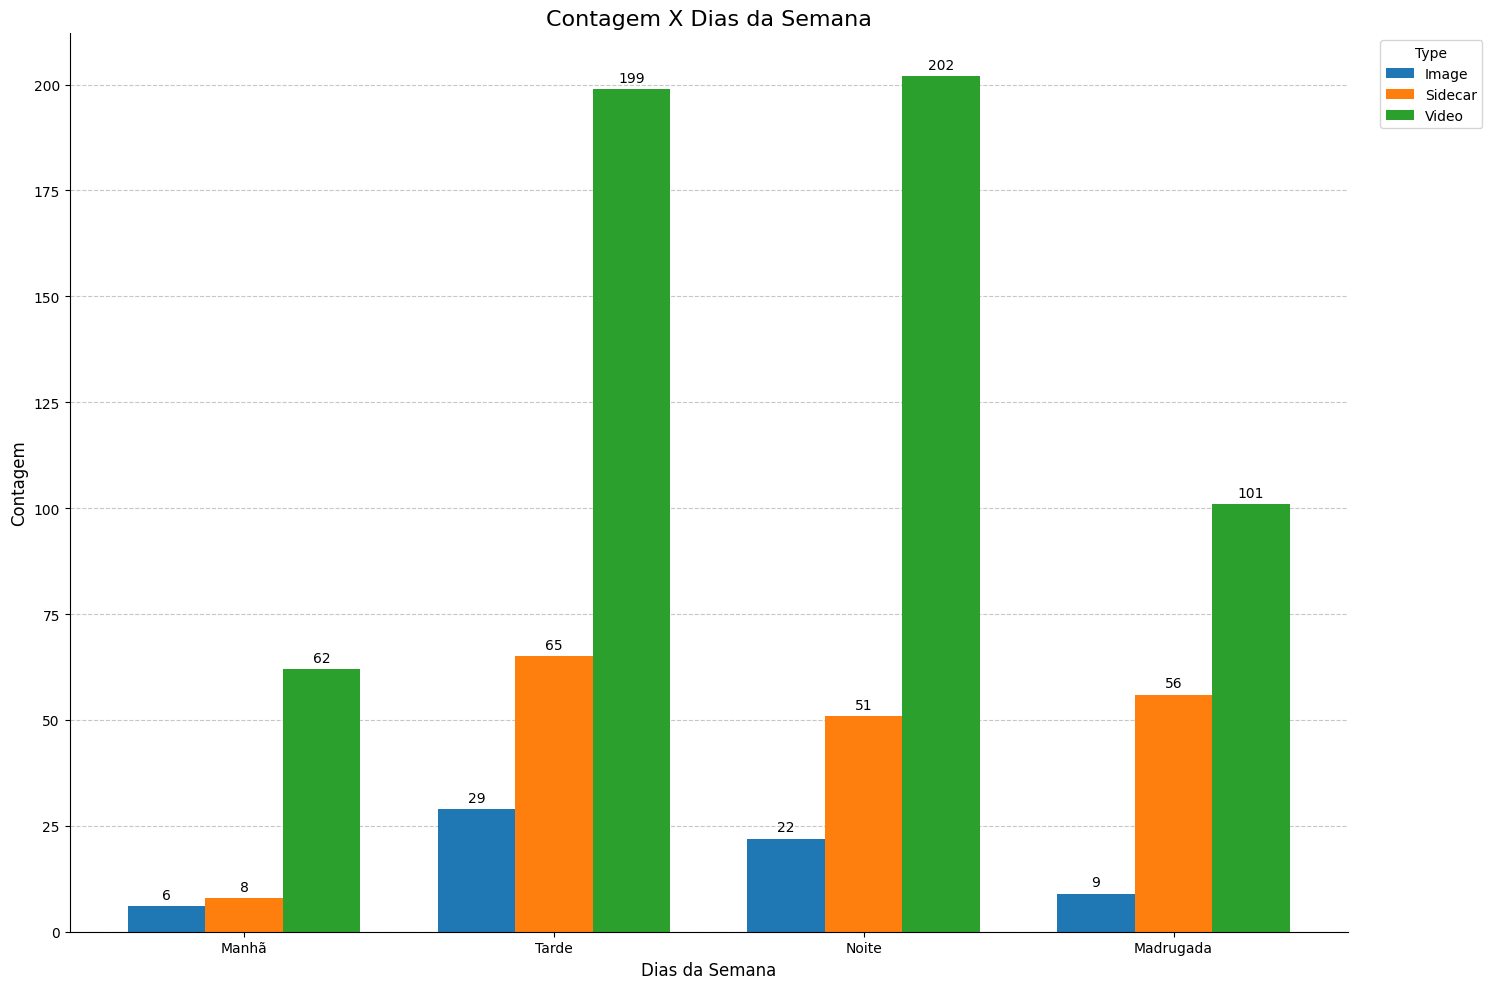

(<_io.BytesIO at 0x23eca9d19e0>,
 {'periodos': type            Image  Sidecar  Video
  PERIODO_DO_DIA                       
  Madrugada           9       56    101
  Manhã               6        8     62
  Noite              22       51    202
  Tarde              29       65    199,
  'dias': type           Image  Sidecar  Video
  DIA_DA_SEMANA                       
  Domingo            7       16     33
  Quarta-feira      11       27     87
  Quinta-feira      14       47    124
  Segunda-feira      8       19     67
  Sexta-feira       13       39    127
  Sábado             4       14     50
  Terça-feira        9       18     76})

In [82]:
def Secao_2_3_Figura9(posts_df, profile_df):

    def tratarDados(posts_df, profile_df):

        # Converte a coluna 'timestamp' para o formato datetime
        posts_df['DATA-HORA'] = pd.to_datetime(posts_df['timestamp'])
                
        # Usamos .dt.day_name() para obter o nome completo do dia da semana em português
        posts_df['DIA_DA_SEMANA'] = posts_df['DATA-HORA'].dt.day_name(locale='pt_BR')

        # --- Extraindo o Período do Dia ---

        # Vamos definir as faixas horárias para cada período
        def get_periodo_do_dia(hour):
            """
            Retorna o período do dia (Manhã, Tarde, Noite, Madrugada)
            com base na hora fornecida (0-23).
            """
            if 5 <= hour < 12:
                return 'Manhã'
            elif 12 <= hour < 18:
                return 'Tarde'
            elif 18 <= hour < 23:
                return 'Noite'
            else:  # Horas da noite (23h) até antes do amanhecer (5h)
                return 'Madrugada'

        # Aplicamos a função à hora de cada datetime
        # Primeiro, extraímos a hora (.dt.hour), depois aplicamos a função
        posts_df['PERIODO_DO_DIA'] = posts_df['DATA-HORA'].dt.hour.apply(get_periodo_do_dia)

        # --- Agrupando os Dados ---

        # Agrupa e conta as postagens por período do dia
        periodo_df = posts_df.groupby(['PERIODO_DO_DIA', 'type']).size().sort_values(ascending=False).reset_index()

        # Agrupa e conta as postagens por dia da semana
        dias_df = posts_df.groupby(['DIA_DA_SEMANA', 'type']).size().sort_values(ascending=False).reset_index()

        # Cria uma tabela pivot com a contagem de tipos de postagem por usuário
        dados_pivot_periodos = periodo_df.pivot(index='PERIODO_DO_DIA', columns='type', values=0)

        # Cria uma tabela pivot com o engajamento total por tipo de postagem e usuário
        dados_pivot_dias = dias_df.pivot(index='DIA_DA_SEMANA', columns='type', values=0)

                # Lista com a nova ordem desejada para as cidades
        ordem_periodos = ['Manhã', 'Tarde', 'Noite', 'Madrugada']
        ordem_dias = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

        periodo_df = dados_pivot_periodos.reindex(ordem_periodos)
        dias_df = dados_pivot_dias.reindex(ordem_dias)

        return dados_pivot_periodos, dados_pivot_dias   

    def plotarBarrasAgrupadas(dados_pivot, x_column, y_column, group_column, ax):

        categorias_principais = dados_pivot.index
        subcategorias = dados_pivot.columns

        n_categorias_principais = len(categorias_principais)
        n_subcategorias = len(subcategorias)

        x = np.arange(n_categorias_principais)
        largura_barra = 0.25

        # 5. Loop para criar as barras para cada subcategoria (cada produto)
        for i, produto in enumerate(subcategorias):
            # Cálculo da posição de cada barra dentro do grupo.
            # O cálculo desloca cada conjunto de barras em relação ao centro do grupo (x).
            # O objetivo é centralizar o cluster de barras em torno do tick do eixo X.
            posicao = x - (largura_barra * n_subcategorias / 2) + (i * largura_barra) + (largura_barra / 2)
            
            # Pega os valores para o produto atual
            valores = dados_pivot[produto]
            
            # Cria as barras
            barra = ax.bar(posicao, valores, largura_barra, label=produto)

            # Adiciona os rótulos de valor no topo de cada barra para clareza
            ax.bar_label(barra, padding=3, fmt='%d') # fmt='%d' para mostrar como inteiro


        # 6. Adicionar rótulos, título, legenda e outros detalhes de formatação
        ax.set_xlabel(x_column, fontsize=12)
        ax.set_ylabel(y_column, fontsize=12)
        ax.set_title(f'{y_column} X {x_column}', fontsize=16)

        # Posiciona os rótulos da categoria principal (Anos) no centro dos grupos de barras
        ax.set_xticks(x)
        ax.set_xticklabels(categorias_principais)

        # Adiciona a legenda para identificar as cores das barras
        ax.legend(title=group_column, bbox_to_anchor=(1.02, 1), loc='upper left')

        # Adiciona uma grade horizontal para facilitar a leitura dos valores
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True) # Coloca a grade atrás das barras

        # Remove as bordas superior e direita para um visual mais limpo
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    dados_pivot_periodos, dados_pivot_dias = tratarDados(posts_df, profile_df)    
    
    # 4. Criar a figura e os eixos do gráfico
    fig, axes = plt.subplots(figsize=(15, 10))

    # Lista com a nova ordem desejada para as cidades
    ordem_periodos = ['Manhã', 'Tarde', 'Noite', 'Madrugada']
    ordem_dias = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

    periodo_df = dados_pivot_periodos.reindex(ordem_periodos)
    dias_df = dados_pivot_dias.reindex(ordem_dias)
    
    plotarBarrasAgrupadas(periodo_df, 'Dias da Semana', 'Contagem', 'Type', axes)

    dataframes = {'periodos': dados_pivot_periodos,
                  'dias': dados_pivot_dias}
    

    # Ajusta o layout para garantir que nada (como a legenda) seja cortado
    fig.tight_layout()

    buffer = io.BytesIO() 
    
    # Para salvar a figura em um arquivo
    plt.savefig(buffer, format='png', dpi=300)

    # 7. Exibir o gráfico
    plt.show()

    #buffer.seek(0)

    return buffer, dataframes

Secao_2_3_Figura9(posts_df, profile_df)

In [17]:
with open(r'..\\data\raw\estrategia.json', 'r', encoding='utf-8') as f:
    dados = json.load(f)

objetivo_principal = dados['objetivo_principal']
objetivo_secundario = dados['objetivo_secundario']
idade = dados['idade']
genero = dados['genero']
localizacao = dados['localizacao']
ocupacao = dados['ocupacao']
renda = dados['renda']
interesses = dados['interesses']
pilares = dados['pilares']
formatos = dados['formatos']